# Unreliable Content Detection in the News

In [1]:
import re
import warnings
import shap
import torch
import random
import textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from IPython.display import display, Markdown
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from IPython.display import display, HTML
from IPython.display import Image as IPimage
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
from src.functions import *

params = {
    "figure.figsize": (6, 5),
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.major.size": 0,
    "ytick.major.size": 0,
    "grid.alpha": 0.9,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "axes.edgecolor": "white",
}
plt.rcParams.update(params)
sns.set_palette("deep")
pd.set_option("display.max_colwidth", None)

# Data Cleaning

The main objectives for this part of the notebook:

- Present available data.
- Discover and address data quality issues.

## Dataset Overview

Some articles in the dataset are very long. For readability, they will be truncated when displayed throughout the project. Depending on the context, either the beginning or the end of the article will be shown to highlight the most relevant part.

### Original Dataset

Two article examples are presented below, along with my understanding of the dataset based on manual review. This includes a general overview of content, labeling patterns, and structural differences between true and fake news entries. Additional markdown explanations summarize a total of six articles (two of which are displayed), providing specific examples of what the dataset considers "true" and "fake".

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

true["label"] = "True"
fake["label"] = "Fake"
original_news = pd.concat([true, fake], ignore_index=True)
original_news = original_news.sample(frac=1, random_state=5).reset_index(drop=True)

display(Markdown("<h4 align='center'>True news (fact based information)</h4>"))
preview_text(true, 1000, 1, "start")
display(Markdown("<h4 align='center'>Fake news (opinion based information)</h4>"))
preview_text(fake, 1000, 1, "end")

pattern = r"reuters"
counts = original_news.groupby("label")["text"].apply(
    lambda x: x.str.contains(pattern, case=False, na=False, regex=True).sum()
)
proportions = counts / original_news["label"].value_counts()
print(f'Presence of "{pattern}" occurrence by label in articles')
display(pd.DataFrame({"Count": counts, "Proportion": proportions}))

print(f"\nOriginal number of fake news articles: {fake.shape[0]}")
print(f"Original number of real news articles: {true.shape[0]}")
print(f"Total number of articles before cleaning: {true.shape[0] + fake.shape[0]}")

<h4 align='center'>True news (fact based information)</h4>

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educati",politicsNews,"December 31, 2017",True


<h4 align='center'>Fake news (opinion based information)</h4>

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017",Fake


Presence of "reuters" occurrence by label in articles


,Count,Proportion
label,,
Fake,322,0.013713
True,21378,0.998179



Original number of fake news articles: 23481
Original number of real news articles: 21417
Total number of articles before cleaning: 44898


- Vast majority of news articles focus on Donald Trump, his administration, and political controversies, with only a few covering non-political events and individuals.
- Fake news frequently relies on highly charged language and social media reactions to shape perception. Truthful articles tend to rely on official sources, government agencies, or court rulings. They use factual language rather than emotional or opinion-driven framing and often cite multiple sources. Unlike misleading articles, they do not rely on social media reactions.
- Almost all of the true articles I've seen include a note at the beginning stating that they come from Reuters. This is consistent with how Reuters presents content on their website to this day - their editorial convention. This may also introduce a form of data leakage.
- Fake news articles typically do not include any clear mention of where they come from, but they often contain metadata not seen in true articles, such as "Photo by Andrew Burton/Getty Images." at the end. This may also constitute data leakage and suggest that many originate from the same unspecified news agency.

Fake news explanations for three articles:

- The first exaggerates Trump's New Year's tweet, portraying it as unusually shocking despite similar past statements.  
- The second misrepresents the Steele dossier's role in the Russia investigation and sensationalizes Papadopoulos’s drunkenness.  
- The third focuses on ridicule and social media reactions rather than neutral reporting, shaping public perception instead of presenting facts objectively.

Real news explanations for three articles:

- The first article discusses the U.S. budget fight, highlighting Republican shifts in fiscal policy. It presents statements from political figures and references ongoing congressional debates.  
- The second article reports on the U.S. military’s acceptance of transgender recruits following court rulings. It cites official Pentagon statements and legal decisions, which are public records.  
- The third article covers Senator Lindsey Graham’s stance on Robert Mueller’s Russia investigation. It includes direct quotes and references to political discussions.

### Additional New Dataset for Testing

The original dataset is heavily biased, with all true-labeled articles coming from a single source—Reuters. As a result, models trained on this data would learn to identify whether an article could come from Reuters or not, rather than detecting actual fake content, leading to overfitting. To evaluate whether the discovered patterns are generalizable, I introduced an external test set from Kaggle containing new news articles.

In [3]:
new_test = pd.read_csv("fake_or_real_news.csv")
new_test = new_test.drop(columns=["Unnamed: 0"])
new_test["label"] = new_test["label"].map({"FAKE": "Fake", "REAL": "True"})
preview_text(new_test, 1000, 1, "start")
print(f"Total number of articles before cleaning: {new_test.shape[0]}")
print(f"The original dataset is {len(original_news)/len(new_test):.1f} times larger than the new")

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. \nThe word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. \nBut that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. \nThe FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. \nThe FBI’s leadership is being warned that the entire left",Fake


Total number of articles before cleaning: 6335
The original dataset is 7.1 times larger than the new


- The external dataset also focuses on political topics, which aligns well with the subject matter of the original dataset.
- This dataset was added later in the project and will be explored less than the original data.

## Missing Values

Missing values provide no useful information for the model—there’s nothing to learn from them during training, and they contribute nothing during testing. Keeping them would only introduce noise or errors, so they are removed.

### Original Dataset

In [4]:
empty_articles = original_news[original_news["text"].str.strip() == ""]
print("Number of missing values:", original_news.isnull().sum().sum())
print(f"Number of empty articles: {len(empty_articles)}")

Number of missing values: 0
Number of empty articles: 631


- No missing values, but 631 articles have no text. They will be removed.

In [5]:
original_news = original_news[original_news["text"].str.strip() != ""]
original_news.reset_index(drop=True, inplace=True)
print(f"Number of articles after removing empty entries: {original_news.shape[0]}")

Number of articles after removing empty entries: 44267


### New Testing Dataset

In [6]:
empty_articles = new_test[new_test["text"].str.strip() == ""]
print("Number of missing values:", new_test.isnull().sum().sum())
print(f"Number of empty articles: {len(empty_articles)}")

Number of missing values: 0
Number of empty articles: 36


- No missing values, but 36 articles have no text.

In [7]:
new_news = new_test[new_test["text"].str.strip() != ""]
new_news.reset_index(drop=True, inplace=True)
print(f"Number of articles after removing empty entries: {new_news.shape[0]}")

Number of articles after removing empty entries: 6299


## Duplicates

Whether to keep duplicates depends on the production setting—some sites may repost content, while reputable organizations typically avoid it. However, since this dataset is biased and not a random sample from the internet, I can't assume that duplicates reflect natural behavior. And if there would be duplicates, it would not be the ones we have in this dataset.

### Original Dataset

In [8]:
dup_title = original_news.duplicated(subset=["title"])
dup_text = original_news.duplicated(subset=["text"])
overlap_count = (dup_title & dup_text).sum()
title_in_text_pct = overlap_count / dup_title.sum() * 100
text_in_title_pct = overlap_count / dup_text.sum() * 100

dup_texts = original_news[original_news.duplicated(subset=["text"], keep=False)]
dup_title_mask = original_news.duplicated(subset=["title"], keep=False)
dup_text_mask = original_news.duplicated(subset=["text"], keep=False)
title_dup_text_unique = original_news[dup_title_mask & ~dup_text_mask]

print("Duplicate by text example:")
preview_text(dup_texts.sort_values("title"), 500, 2, "start")

print("Articles with duplicate titles but different text example:")
preview_text(title_dup_text_unique.sort_values("title"), 500, 2, "end")

print(
    f"\nTotal fully duplicated rows (all columns): {original_news.duplicated().sum()}"
)
print(f"Rows with duplicate titles: {dup_title.sum()}")
print(f"Rows with duplicate text content: {dup_text.sum()}")
print(f"\nOf the title duplicates, {title_in_text_pct:.2f}% also have duplicate text.")
print(f"Of the text duplicates, {text_in_title_pct:.2f}% also have duplicate titles.")

Duplicate by text example:


,title,text,subject,date,label
11116,#AnyoneButHillary: NEW POLL Shows Bernie Supporters WON’T Vote For Hillary…Who They’ll Vote For If Hillary’s The Nominee May Surprise You,"Hillary may find out she needs more than black women drag her lying criminal ass over the finish line Actress and Bernie Sanders supporter Susan Sarandon recently received shock and criticism for suggesting she may not vote for Hillary Clinton in the general election. She s not alone. According to a recent McClatchy-Marist Poll conducted on March 29-31, 25 percent of Sanders supporters would not support her, while 69 percent would. Sanders voters are even more committed to him and perhaps agai",left-news,"Apr 6, 2016",Fake
27906,#AnyoneButHillary: NEW POLL Shows Bernie Supporters WON’T Vote For Hillary…Who They’ll Vote For If Hillary’s The Nominee May Surprise You,"Hillary may find out she needs more than black women drag her lying criminal ass over the finish line Actress and Bernie Sanders supporter Susan Sarandon recently received shock and criticism for suggesting she may not vote for Hillary Clinton in the general election. She s not alone. According to a recent McClatchy-Marist Poll conducted on March 29-31, 25 percent of Sanders supporters would not support her, while 69 percent would. Sanders voters are even more committed to him and perhaps agai",politics,"Apr 6, 2016",Fake


Articles with duplicate titles but different text example:


,title,text,subject,date,label
4932,McConnell Says He’ll Obstruct ANY Effort To Hire Independent Special Prosecutor,"risis, McConnell is choosing to smear his Democratic enemies and stand with undemocratic strongarm tactics from a president. It was a disgusting display of partisanship in the face of an unprecedented move by a sitting president to silence his critics and kill an investigation into his own wrongdoing. Having watched McConnell spend a decade refining the art of obstruction, it appears that this final act of obstruction of justice will be his masterpiece.Featured image via Win McNamee/Getty Images",News,"May 10, 2017",Fake
31684,McConnell Says He’ll Obstruct ANY Effort To Hire Independent Special Prosecutor,"choosing to smear his Democratic enemies and stand with undemocratic strongarm tactics from a president. It was a disgusting display of partisanship in the face of an unprecedented move by a sitting president to silence his critics and kill an investigation into his own wrongdoing. Having watched McConnell spend a decade refining the art of obstruction, it appears that this final act of obstruction of justice will be his masterpiece.Featured image via Aaron P. Bernstei /Stringer via Getty Images",News,"May 12, 2017",Fake



Total fully duplicated rows (all columns): 209
Rows with duplicate titles: 5985
Rows with duplicate text content: 5623

Of the title duplicates, 93.72% also have duplicate text.
Of the text duplicates, 99.75% also have duplicate titles.


- Most duplicates appear to be the same articeles with different subject tag (visible from "Duplicate by text example").
- Some articles are identified as duplicates by title despite not having identical text. These cases typically differ only in minor details, such as the image attribution at the end.

In [9]:
initial_len = len(original_news)
original_news = original_news.drop_duplicates()
after_full_drop = len(original_news)
dropped_full = initial_len - after_full_drop

original_news = original_news.drop_duplicates(subset=["title"])
after_title_drop = len(original_news)
dropped_title = after_full_drop - after_title_drop

original_news = original_news.drop_duplicates(subset=["text"])
after_text_drop = len(original_news)
dropped_text = after_title_drop - after_text_drop

original_news.reset_index(drop=True, inplace=True)
total_dropped = dropped_full + dropped_title + dropped_text
print(f"Dropped full row duplicates: {dropped_full}")
print(f"Dropped title duplicates: {dropped_title}")
print(f"Dropped text duplicates: {dropped_text}")
print(f"Total duplicates dropped: {total_dropped}")
print(f"Final row count: {after_text_drop}")

Dropped full row duplicates: 209
Dropped title duplicates: 5776
Dropped text duplicates: 14
Total duplicates dropped: 5999
Final row count: 38268


### New Testing Dataset

In [10]:
dup_title = new_test.duplicated(subset=["title"])
dup_text = new_test.duplicated(subset=["text"])

print(f"Total fully duplicated rows (all columns): {new_test.duplicated().sum()}")
print(f"Rows with duplicate titles: {dup_title.sum()}")
print(f"Rows with duplicate text content: {dup_text.sum()}")

Total fully duplicated rows (all columns): 29
Rows with duplicate titles: 79
Rows with duplicate text content: 275


- There are duplicates.

In [11]:
initial_len = len(new_test)
new_test = new_test.drop_duplicates(subset=["title"])
after_title = len(new_test)
dropped_title = initial_len - after_title
new_test = new_test.drop_duplicates(subset=["text"])
after_text = len(new_test)
dropped_text = after_title - after_text
new_test.reset_index(drop=True, inplace=True)

total_dropped = dropped_title + dropped_text
print(f"Dropped duplicate titles: {dropped_title}")
print(f"Dropped duplicate texts: {dropped_text}")
print(f"Total duplicates dropped: {total_dropped}")
print(f"Final dataset size: {after_text}")

Dropped duplicate titles: 79
Dropped duplicate texts: 245
Total duplicates dropped: 324
Final dataset size: 6011


### Duplication Between the Two Datasets

The example below shows one entry from one datase and the other from another one.

In [12]:
matching_titles = new_test["title"].isin(original_news["title"])
matching_text = new_test["text"].isin(original_news["text"])
matched_new = new_test[matching_titles]
matched_original = original_news[original_news["title"].isin(matched_new["title"])]
matched_rows = pd.concat([matched_new, matched_original], ignore_index=True)
matched_rows = matched_rows.sort_values("title").reset_index(drop=True)
preview_text(matched_rows, 800, 2, "start")
print(f"Matching titles: {matching_titles.sum()}")
print(f"Matching texts: {matching_text.sum()}")

,title,text,label,subject,date
0,"Episode #159 – SUNDAY WIRE: ‘Tick-Tock USA’ with guests Dr Marcus Papadopoulos, Basil Valentine","November 6, 2016 By 21wire Leave a Comment \nEpisode #159 of SUNDAY WIRE SHOW resumes this November 6, 2016 as host Patrick Henningsen brings a 3 HOURS special broadcast of LIVE power-packed talk radio on ACR… \nLISTEN LIVE ON THIS PAGE AT THE FOLLOWING SCHEDULED SHOW TIMES: \nSUNDAYS – 5pm-8pm UK Time | 12pm-3pm ET (US) | 9am-12pm PT (US) \nThis week’s edition of THE SUNDAY WIRE is on the road broadcasting LIVE from the Valley of the Sun. This week host Patrick Henningsen covers this week’s top stories in the US and internationally. In the first hour we’re joined by a very special guest, Dr Marcus Papadopoulos , founder & editor of UK-based publication Politics First to discuss the US Elections and an evaluation of Trump vs Clinton from an international and foreign policy perspective looking",Fake,NaN,NaN
1,"Episode #159 – SUNDAY WIRE: ‘Tick-Tock USA’ with guests Dr Marcus Papadopoulos, Basil Valentine","Episode #159 of SUNDAY WIRE SHOW resumes this November 6, 2016 as host Patrick Henningsen brings a 3 HOURS special broadcast of LIVE power-packed talk radio on ACR LISTEN LIVE ON THIS PAGE AT THE FOLLOWING SCHEDULED SHOW TIMES:SUNDAYS 5pm-8pm UK Time | 12pm-3pm ET (US) | 9am-12pm PT (US)This week s edition of THE SUNDAY WIRE is on the road broadcasting LIVE from the Valley of the Sun. This week host Patrick Henningsen covers this week s top stories in the US and internationally. In the first hour we re joined by a very special guest, Dr Marcus Papadopoulos, founder & editor of UK-based publication Politics First to discuss the US Elections and an evaluation of Trump vs Clinton from an international and foreign policy perspective looking at big bigs like US-NATO and Russian relations as",Fake,Middle-east,"November 6, 2016"


Matching titles: 8
Matching texts: 0


- 8 articles between the two datafarmes have identical titles but differ in wording within the content, even though they discuss the same topic. This information will not be removed.

## Language Check

Langdetect will be used on the article text.

### Original Dataset

In [13]:
original_news["identified_language"] = original_news["text"].apply(safe_langdetect)
non_english_titles = original_news[original_news["identified_language"] != "en"]
original_news.drop(["identified_language"], axis=1, inplace=True)
print("Examples of titles identified as non-English:")
display(non_english_titles[["title", "text", "label", "identified_language"]].head())
print(f"Number of articles identified as non-English: {non_english_titles.shape[0]}")

Examples of titles identified as non-English:


,title,text,label,identified_language
847,BREAKING: UNDERCOVER VIDEO Exposes Hillary’s Dirty Operatives Inciting Violence At Trump Rallies: “We need to win this motherf*cker” [Video],LANGUAGE WARNING!,Fake,de
2979,‘YOU’RE A SEXIST PIG!’ FEMINIST BATTLES Tucker Carlson over IvankaGate [Video],https://www.youtube.com/watch?v=YeDU6dCR9tA,Fake,unknown
3371,WORKING CLASS REVOLT! OLD SCHOOL JERSEY PATRIOTS Let The Liberals and Hollywood Have It! [VIDEO],HE WILL NOT DIVIDE US .,Fake,de
3947,SARA CARTER WAS RIGHT ABOUT SPYING ON TRUMP! “This goes far beyond what is being reported” [VIDEO],https://www.youtube.com/watch?v=Ws5ojb0PCCo,Fake,unknown
4173,BREAKING: PRESIDENT TRUMP Signs Most Important Executive Order “To Ease The Burden”,Via: NPR,Fake,sw


Number of articles identified as non-English: 79


- 79 articles were indentified as non-English. After reviewing the flagged cases, I found that all were actually in English. The text was very short, or contained links.

### New Testing Dataset

In [14]:
new_test["identified_language"] = new_test["text"].apply(safe_langdetect)
non_english_titles = new_test[new_test["identified_language"] != "en"]
new_test.drop(["identified_language"], axis=1, inplace=True)
print("Examples of titles identified as non-English:")
display(non_english_titles[["title", "text", "label", "identified_language"]].tail(1))
print(f"Number of articles identified as non-English: {non_english_titles.shape[0]}")

Examples of titles identified as non-English:


,title,text,label,identified_language
3767,EndingFed News Network | Syndicated news and opinion website providing continuously updated headlines to top news and analysis sources.,RECENT POSTS,Fake,de


Number of articles identified as non-English: 6


- In the flagged cases, one article contains a mix of English and Hindi text, while the others are all very short.

## Date Format Inconsistencies

During EDA, I found inconsistencies in the date formats. I will fix these issues to ensure consistent and usable date information.

In [15]:
invalid_dates = fake[~fake["date"].str.match(r"^[A-Za-z]+ \d{1,2}, \d{4}$", na=False)]

short_month_mask = fake["date"].str.match(r"^[A-Z][a-z]{2} \d{1,2}, \d{4}$", na=False)
full_month_mask = fake["date"].str.match(r"^[A-Z][a-z]+ \d{1,2}, \d{4}$", na=False)
short_month_dates = fake.loc[short_month_mask, "date"]
full_month_dates = fake.loc[full_month_mask, "date"]

print(f"Total dates with short month names (%b): {len(short_month_dates)}")
print(short_month_dates.head().tolist())
print(f"\nTotal dates with full month names (%B): {len(full_month_dates)}")
print(full_month_dates.head().tolist())

print(f"\nAdditional unusual date entries totaling {len(invalid_dates)}:")
print(invalid_dates["date"].unique())

Total dates with short month names (%b): 13745
['May 31, 2017', 'May 31, 2017', 'May 31, 2017', 'May 31, 2017', 'May 31, 2017']

Total dates with full month names (%B): 23436
['December 31, 2017', 'December 31, 2017', 'December 30, 2017', 'December 29, 2017', 'December 25, 2017']

Additional unusual date entries totaling 45:
['19-Feb-18' '18-Feb-18' '17-Feb-18' '16-Feb-18' '15-Feb-18' '14-Feb-18'
 'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
 'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/'
 'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/'
 'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg'
 'https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg'
 'MSNBC HOST Rudely Assumes Steel Worker Would Never Let H

- Some dates use shortened month names like "Dec 31, 2017", while others use the full month name, such as "December 31, 2017".  
- 45 rows contain non-date values (e.g., URLs, plain text) or unclear formats where the year and day cannot be reliably identified.

Unclear and non-date values (45 rows) are set to NaN's, and valid dates are converted to datetime.

In [16]:
# Set invalid or missing date strings to NaN
mask = original_news["label"] == "Fake"
valid_date_pattern = r"^[A-Za-z]+ \d{1,2}, \d{4}$"
original_news.loc[mask, "date"] = original_news.loc[mask, "date"].where(
    original_news.loc[mask, "date"].str.match(valid_date_pattern, na=False),
    other=pd.NaT,
)

# Convert valid strings to datetime format
original_news.loc[mask, "date"] = pd.to_datetime(
    original_news.loc[mask, "date"], format="%b %d, %Y", errors="coerce"
).fillna(
    pd.to_datetime(original_news.loc[mask, "date"], format="%B %d, %Y", errors="coerce")
)
original_news["date"] = pd.to_datetime(original_news["date"], errors="coerce")

## Anomaly Detection

I will check for any entries that do not belong with news articles.

### N-gram Extraction

The text is tokenized using a bag-of-words model with bi- and tri-grams. Frequencies are calculated using CountVectorizer, and the most frequent n-grams are identified per label. Differences are then computed by comparing the all n-grams in each group. The n-grams are sorted descendingly with most common at the top. They were first calcculated to detect data leakage.

In [17]:
fake_ngrams = get_ngram_freq(original_news[original_news["label"] == "Fake"]["text"])
true_ngrams = get_ngram_freq(original_news[original_news["label"] == "True"]["text"])
combined_top = (fake_ngrams.add(true_ngrams, fill_value=0)).sort_values(ascending=False)
fake_only = fake_ngrams[~fake_ngrams.index.isin(true_ngrams.index)].sort_values(
    ascending=False
)
true_only = true_ngrams[~true_ngrams.index.isin(fake_ngrams.index)].sort_values(
    ascending=False
)

print_ngrams(
    "Most frequent n-grams overall (bi and tri):",
    combined_top.index.tolist(),
    max_ngrams=20,
)
print_ngrams(
    "N-grams common in Fake News but not in True News:",
    fake_only.index.tolist(),
    max_ngrams=50,
)
print_ngrams(
    "N-grams common in True News but not in Fake News:",
    true_only.index.tolist(),
    max_ngrams=50,
)


Most frequent n-grams overall (bi and tri):
donald trump, united states, white house, hillary clinton, new york, featured image, washington reuters, president donald, president donald trump, twitter com, north korea, pic twitter, pic twitter com, barack obama, trump said
year old, prime minister, getty images, supreme court, said statement

N-grams common in Fake News but not in True News:
featured image, twitter com, pic twitter, pic twitter com, getty images, president obama, fox news, president trump, trump realdonaldtrump, donald trump realdonaldtrump, republican party, ted cruz, screen capture, fake news, 2017 realdonaldtrump
american people, social media, 21st century, right wing, trump supporters, york times, new york times, bernie sanders, washington post, law enforcement, don know, century wire, 21st century wire, image video, lives matter
black lives, president united, black lives matter, president united states

N-grams common in True News but not in Fake News:
washington r

### N-gram-Based Anomaly Inspection

When reviewing n-grams for data leakage (section further down), I found that some patterns indicated non-news content.

In [18]:
pattern_exploration(original_news, r"boiler room", rows=2, n_chars=800, position="start")
pattern_exploration(original_news, r"The following statements", rows=2, n_chars=800, position="start")


PATTERN ANALYSIS: "boiler room"

Proportion of articles containing the pattern:


,Count,Proportion
label,,
Fake,110,0.006304
True,0,0.000000



Example rows containing the pattern:


,title,text,subject,date,label
52,"BOILER ROOM – EP #48 – Agenda 2030 and Beyond with Branko Malić, Patrick Henningsen & Mike Robinson","Tune in to the Alternate Current Radio Network (ACR) for another LIVE broadcast of The Boiler Room starting at 6 PM PST | 9 PM EST every Wednesday. Join us for uncensored, uninterruptible talk radio, custom-made for barfly philosophers, misguided moralists, masochists, street corner evangelists, media-maniacs, savants, political animals and otherwise lovable rascals.Join ACR hosts Hesher, & Spore along with Branko Mali of Kali Tribune, Mike Robinson from UK Column and Patrick Henningsen of 21stcenturywire. In this broadcast listeners will be hearing us go around the BOILER ROOM on the encroaching UN Agenda 2030, the European migrant crisis, the US political climate and a variety of other topics on this special edition of THE BOILER ROOM. If you want to participate, bring something intere",US_News,2016-03-16,Fake
336,Boiler Room EP #118,"Tune in to the Alternate Current Radio Network (ACR) for another LIVE broadcast of The Boiler Room tonight 6:00 PM PST | 8:00 PM CST | 9:00 PM EST for this special broadcast. Join us for uncensored, uninterruptible talk radio, custom-made for bar fly philosophers, misguided moralists, masochists, street corner evangelists, media-maniacs, savants, political animals and otherwise lovable rascals.Join ACR hosts Hesher and Spore along side Daniel Spaulding Soul of the Eastof and FunkSoul & Randy J (21WIRE & ACR contributors), for the hundred and eighteenth episode of BOILER ROOM. Turn it up, tune in and hang with the ACR Brain-Trust for this weeks boil downs and analysis and the usual gnashing of the teeth of the political animals in the social reject club.This week on the show the ACR Brain",US_News,2017-07-20,Fake



PATTERN ANALYSIS: "The following statements"

Proportion of articles containing the pattern:


,Count,Proportion
label,,
Fake,0,0.000000
True,93,0.004467



Example rows containing the pattern:


,title,text,subject,date,label
59,"Factbox: Trump on Twitter (Sept 14) - DACA, U.S.-Mexico border wall","The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS. The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy. @realDonaldTrump : - No deal was made last night on DACA. Massive border security would have to be agreed to in exchange for consent. Would be subject to vote. [0611 EDT] - The WALL, which is already under construction in the form of new renovation of old and existing fences and walls, will continue to be built. [0620 EDT] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR)",politicsNews,2017-09-14,True
259,"Factbox: Trump on Twitter (September 18) - CIA, U.N., Macron, Netanyahu","The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS. The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy. @realDonaldTrump : - Happy 70th Birthday @USAirForce! [0914 EDT] - Happy 70th Birthday @CIA! [0916 EDT] - We commend SG @AntonioGuterres & his call for the UN to focus more on people & less on bureaucracy. #USAatUNGA #UNGA 45.wh.gov/K2mggs [1236 EDT] - Looking forward to meeting with Prime Minister @Netanyahu shortly. Peace in the Middle East would be a truly great legacy for ALL people! [1257 EDT] - Such an honor to have my good friend, Israel PM @Netanyahu, join us w/ his delegation in NYC this afternoon. #UNGA 45.wh.gov/Israel [1931 EDT] - It was a",worldnews,2017-09-19,True


- The pattern "boiler room" appears in 110 advertisements for the podcast "The Boiler Room".
- The pattern "The following statements" is used in 95 entires to quote Trump tweets, preceded by a disclaimer from Reuters stating they do not endorse the content. 
- All of the mentioned cases are fake news.

I will keep these cases in the dataset as the intended production environment is unknown for me. I will treat them as representative of the types of content the model may encounter in practice.

### Semantic Sentence Embeddings

I manually identified some unusual entries, but there may be more. To perform a more thorough detection, each article will be encoded into a vector using a pretrained transformer (all-MiniLM-L6-v2) to capture its semantic meaning. These vectors will then be passed to an Isolation Forest, which assigns an anomaly score based on how different each article is from the rest. Lower scores indicate a higher likelihood of being off-topic or structurally unusual. I will review the lowest-scoring articles to determine if they are truly anomalous.

In [19]:
texts = original_news["text"].tolist()
model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")
embeddings = model.encode(texts, batch_size=32, show_progress_bar=False)
clf = IsolationForest(random_state=5)
clf.fit(embeddings)
scores = clf.decision_function(embeddings)
original_news["anomaly_score"] = scores
display(original_news.sort_values("anomaly_score", ascending=True).head(1))
original_news.drop(columns=["anomaly_score"], inplace=True)

,title,text,subject,date,label,anomaly_score
29092,Boiler Room #88 – Behold: Your New Ministry of Truth,"Tune in to the Alternate Current Radio Network (ACR) for another LIVE broadcast of The Boiler Room starting at 6:00 PM PST | 8:00 PM CST | 9:00 PM EST for this special broadcast. Join us for uncensored, uninterruptible talk radio, custom-made for barfly philosophers, misguided moralists, masochists, street corner evangelists, media-maniacs, savants, political animals and otherwise lovable rascals.Join ACR hosts Hesher and Spore along with Jay Dyer (author of Esoteric Hollywood) and Jamie Hanshaw, host of Happy Hearts Radio for the 88th episode of BOILER ROOM. Water the plants, put the kids to bed and get your favorite snuggy out so you can drop deep into the Boiler Room with the ACR brain-trust.Caller line was open for BOILER ROOM EP #88:Please like and share the program and visit our donate page to get involved!BOILER ROOM IS NOT A POLICTALLY CORRECT ZONE! LISTEN TO THE SHOW IN THE PLAYER BELOW ENJOY! Listen to Boiler Room #87 Behold: The New Ministry of Truth on Spreaker.Reference Links:",US_News,2016-12-15,Fake,-0.002907


- After reviewing the articles flagged as most anomalous by the model, I found that the lowest-scoring entries were still actual news articles and not truly off-topic. 
- Some entries ranked slightly higher in the anomaly list were very short and did not resemble news content.

### Short Text Inspection

I will review articles of varying lengths to determine whether very short entries contain meaningful content. By reading samples at different lengths, I aim to identify a word count threshold below which entries should be removed from the dataset.

In [20]:
show_short_texts(original_news, 3, 5)
show_short_texts(original_news, 2, 5)


Number of rows with 3 or fewer words: 85
Labels present: ['Fake']


,title,text,subject,date,label,word_count
37150,UNREAL! THIS ONE PHOTO SUMS UP The Anti-Trump Liberal Wackos,Great parenting huh?,politics,2016-05-02,Fake,3
4634,WATCH: BEST DESCRIPTION OF UK BREXIT YET…Conservatives Will Stand Up And Cheer!,Take note America,politics,2016-06-26,Fake,3
11128,THE VIDEO HILLARY CLINTON Does NOT Want You To See,Spread this EVERYWHERE!,left-news,2016-03-09,Fake,3
8694,MUST SEE: House Oversight Committee Releases Most Damning Video Of Hillary’s Lies To Date,Crooked lying Hillary,politics,2016-08-16,Fake,3
13696,4TH OF JULY HUMOR: Brutal Cartoon Shows Difference Between Liberals And Proud Americans,Boom!Courtesy of: comicallyincorrect.com,left-news,2016-07-04,Fake,3



Number of rows with 2 or fewer words: 72
Labels present: ['Fake']


,title,text,subject,date,label,word_count
847,BREAKING: UNDERCOVER VIDEO Exposes Hillary’s Dirty Operatives Inciting Violence At Trump Rallies: “We need to win this motherf*cker” [Video],LANGUAGE WARNING!,politics,2016-10-17,Fake,2
6057,HYSTERICAL! HERE’S WHY TRUMP SAID TO REPORTER: “I’m president and you’re not”,Read more:WT,politics,2017-03-23,Fake,2
11330,TRUMP HATER MEGYN KELLY Pummeled In Ratings While Hannity Soars!,Via: GP,politics,2016-10-15,Fake,2
10542,ANTI-HILLARY HALLOWEEN HOUSE Gets Violent Threats You Won’t Believe…This Woman Is So Brave! [Video],Via: TMZ,politics,2016-10-30,Fake,2
23055,Anti-Trump Protesters Scream Profanities at FOX News in Segment on Peaceful Protests,Lefty losers,left-news,2016-03-11,Fake,2


- Entries with up to two words often contain text that is not meaningful to a human reader, while three-word entries offer slightly more content, though all are labeled as fake.  
- All entries up to 18 words are labeled as fake and typically have heavily capitalized titles.  

I will assume these cases are representative of the production environment and will keep them in the dataset, though I am doubtful that all very short articles would truly be fake in deployment. Such data may introduce some bias for very short text.

## Data Leakage

It is not ideal for a model to make predictions based on just a few specific tokens. For example, a line stating that the article comes from Reuters could easily manipulate the model’s prediction. This issue stems from the data—not the model itself. Well-constructed datasets should not include such easily exploitable patterns. These should be removed from the training data.

I reviewed various n-grams and individual words, and present only those that appear to be clear cases of data leakage. In each case, the pattern can also be considered metadata rather than meaningful article content.

In [21]:
print("Patterns that appear in a single label:")
pattern_exploration(original_news, r"reuters\) -", rows=1, n_chars=500, position="start")
pattern_exploration(original_news, r"featured image", rows=1, n_chars=500, position="end")
pattern_exploration(original_news, r"getty images", rows=1, n_chars=500, position="end")
pattern_exploration(original_news, r"pic.twitter", rows=1, n_chars=1000, position="end")
pattern_exploration(original_news, r"https", rows=1, n_chars=700, position="end")
pattern_exploration(original_news, r"21st Century Wire", rows=1, n_chars=500, position="start")

Patterns that appear in a single label:

PATTERN ANALYSIS: "reuters\) -"

Proportion of articles containing the pattern:


,Count,Proportion
label,,
Fake,0,0.000000
True,20661,0.992363



Example rows containing the pattern:


,title,text,subject,date,label
0,Supreme Court sympathetic to property owner in wetlands dispute,"WASHINGTON (Reuters) - The U.S. Supreme Court on Wednesday appeared likely to rule that property owners can challenge the federal government in court over the need for permits under a national water protection law in a case involving a company’s plans for a Minnesota peat mine. The court heard a one-hour argument in a case balancing property rights and environmental law, in this instance the landmark 1972 U.S. Clean Water Act. A majority of the eight justices appeared sympathetic toward North Da",politicsNews,2016-03-30,True



PATTERN ANALYSIS: "featured image"

Proportion of articles containing the pattern:


,Count,Proportion
label,,
Fake,8159,0.467618
True,0,0.000000



Example rows containing the pattern:


,title,text,subject,date,label
4,Ted Cruz: I’m ‘Honored’ By Support Of This Demon-Obsessed Exorcist Preacher (VIDEO),"o Leadership Team with the endorsement of 25 current and former elected officials and key grassroots leaders, including Klingenschmitt.If this doesn t tell you what kind of president Ted Cruz would be, I don t know what will. He might be smart enough not to say this stuff so blatantly himself, but if he didn t share these same extreme views, he wouldn t surround himself with these people.Be afraid, be very afraid of the possibility of a President Ted Cruz.Featured image via video screen capture",News,2016-04-10,Fake



PATTERN ANALYSIS: "getty images"

Proportion of articles containing the pattern:


,Count,Proportion
label,,
Fake,3942,0.225928
True,0,0.000000



Example rows containing the pattern:


,title,text,subject,date,label
5,California May Stop Paying Taxes To Federal Government After Trump Threatens To Defund The State (DETAILS),"ld be a weapon. Ir would be a weapon, but the federal government needs California s money more than the state needs funding from the government. This fact alone is enough to virtually assure that lawmakers will choose to defund Trump rather than violate their conscience and hand over people Trump has deemed undesirable. Looks like Trump s threat has been called. It s time to find out if he is really stupid enough to try this kind of stunt.Read more:Featured image via Getty Images (Drew Angerer)",News,2017-02-06,Fake



PATTERN ANALYSIS: "pic.twitter"

Proportion of articles containing the pattern:


,Count,Proportion
label,,
Fake,2694,0.154402
True,0,0.000000



Example rows containing the pattern:


,title,text,subject,date,label
36,WHAT THE MAINSTREAM MEDIA WON’T SHOW YOU: NEW White House Communications Director Anthony Scaramucci Explains Why He Once Called Trump A “Hack” [VIDEO],"er candidate at the time he made the comments about Donald J. Trump.Watch:.@Scaramucci called @POTUS a hack in 2015.He has publicly apologized today. MSM may choose not to show his apology. Both clips back to back pic.twitter.com/euEeNWQgbL Corryn (@Corrynmb) July 21, 2017After his much-talked about attack on undocumented immigrants, Republican presidential candidate Donald Trump is now taking on hedge fund managers, vowing to reform the tax code to ensure they pay their fair share. In a campaign marked by his now-trademark bombastic style, Trump called hedge fund managers paper-pushers, and said he would seek to help the middle-class by lowering their tax burden. The hedge fund guys are getting away with murder. They re making a tremendous amount of money. They have to pay taxes. I want to lower the rates for the middle class. The middle class is the one, they re getting absolutely destroyed. This country doesn t have won t have a middle class very soon, Trump told CBS News.",politics,2017-07-21,Fake



PATTERN ANALYSIS: "https"

Proportion of articles containing the pattern:


,Count,Proportion
label,,
Fake,2514,0.144085
True,0,0.000000



Example rows containing the pattern:


,title,text,subject,date,label
28,Hillary’s New Ad Brilliantly Uses Those Who Have Endorsed Trump Against Him (VIDEO),"ng it.Noticing the clear disdain for Trump s remarks by his Republican allies was the Hillary Clinton campaign, and they brilliantly put together an ad using all of their words against the presumptive nominee.It may become the most damaging ad yet, as Trump may have finally gone too far for even his own party, with Newt Gingrich, a man who has been rumored to be a potential VP for Trump, saying: This is one of the worst mistakes Trump has made. Watch the brilliant ad here:.@realdonaldtrump s bigoted comments about a Latino judge are so disgusting, even other Republicans are offended.https://t.co/3CEBq2jsDh Hillary Clinton (@HillaryClinton) June 6, 2016Featured image via video screen capture",News,2016-06-06,Fake



PATTERN ANALYSIS: "21st Century Wire"

Proportion of articles containing the pattern:


,Count,Proportion
label,,
Fake,629,0.03605
True,0,0.00000



Example rows containing the pattern:


,title,text,subject,date,label
11,"Yahoo caves in to NSA, FBI – and secretly monitors customer email accounts for US Gov’t","21st Century Wire says This will rank as one of the most egregious miscarriages of consumer trust in US history. In a brief statement to Reuters, according to these Silicon Valley executives: Yahoo is a law-abiding company, and complies with the laws of the United States. Actually, Yahoo is in breach of the law. The laws they think they are talking about do not allow for flipping a dead switch on the 4th Amendment and conducting mass surveillance on all US citizens.In reality, the US Consti",Middle-east,2016-10-05,Fake


- At least 99% of true articles come from a single news agency, Reuters, as indicated by the presence of "Reuters) -" at the beginning of the text.
- Many fake articles exclusivly contain images ("featured image") credited to "Getty Images" or links to Twitter ("pic.twitter") and other websites ("https").
- Additionally, some fake articles mention "21st Century Wire" as their source, often using distinct templates at the beginning of the text - this is why there are two separate entries presented for it.
- Articles from "21st Century Wire" often end with phrases that may leak the label too, but these endings are varied and I did not explore them deeper.

The dataset is split into training and test sets, with 15% allocated to the test set, before removing any data leakage patterns to ensure the test portion remains completely untouched. The same procedure is applied to the data for all modeling methods used, including heuristic, machine learning, and deep learning techniques.

In [22]:
original_train, original_test = train_test_split(
    original_news, test_size=0.15, random_state=5, stratify=original_news["label"]
)

# Remove anything after "featured image" includingg itself
original_train["text"] = (
    original_train["text"]
    .str.replace(r"featured image.*$", "", case=False, regex=True)
    .str.strip()
)

# Remove links starting with "pic.twitter.com" followed by non-space characters
original_train["text"] = (
    original_train["text"]
    .str.replace(r"pic\.twitter\.com\S*", "", case=False, regex=True)
    .str.strip()
)

# Remove all hyperlinks starting with "https" and any non-space characters following it
original_train["text"] = (
    original_train["text"].str.replace(r"https\S+", "", regex=True).str.strip()
)

# Remove the last sentence if it contains "Getty Images"
original_train["text"] = (
    original_train["text"]
    .str.replace(r"[^.]*getty images[^.]*\.$", "", case=False, regex=True)
    .str.strip()
)

# Remove the phrase "21st Century Wire says" if it's at the start of the first sentence
original_train["text"] = original_train["text"].str.replace(
    r"^(21st Century Wire says\s*)", "", regex=True
)

# If "21st Century Wire" appears in the first 200 characters, remove everything up to and including that sentence
mask = original_train["text"].str[:200].str.contains("21st Century Wire", na=False)
original_train.loc[mask, "text"] = (
    original_train.loc[mask, "text"]
    .str.replace(r"^[^.]*?21st Century Wire[^.]*\.", "", regex=True)
    .str.strip()
)

# Removes everything up to and including the first occurrence of "Reuters) -""
mask = original_train["text"].str.contains(r"Reuters\)\s*-\s*", na=False)
original_train.loc[mask, "text"] = (
    original_train.loc[mask, "text"]
    .str.replace(r"^.*?Reuters\)\s*-\s*", "", regex=True)
    .str.strip()
)

## Summary

This is a dataset about politics. It defines "fake" news as emotionally charged content lacking factualily, while "true" articles are neutral and report like. All true-labeled entries come from Reuters, a news agency known for its objective reporting style, making source and tone strong indicators of the label. A simple heuristic like checking whether the article originates from Reuters would achieve very high accuracy. This is a biased dataset, and as a result, the task becomes less about detecting factuality and more about identifying writing style or origin, which inflates model performance and limits its real-world usefulness.

The original dataset contained 44898 entries. After removing empty text and duplicates, 38268 entries remain:

- 715 empty text rows were removed.
- A total of 5,971 duplicates were removed based on full-row matches, identical titles, or identical text. While some text entries had minor differences (e.g., image attribution) with matching titles, it was essentially the same text.
- All text is in English.
- Rows with invalid or unclear date formats were corrected and 45 entries removed due to irrecoverable non-date values such as plain text, URLs, or inconsistent formatting.
- Some unusual patterns were identified by reviewing frequent n-grams, including promotional podcast mentions and reposted tweets with disclaimers. These entries were not removed, as they may reflect real-world cases the model should handle.  
- Anomaly detection using sentence embeddings and Isolation Forest did not reveal any clearly off-topic or structurally unusual articles.  
- Manual inspection of very short entries showed that texts under 3 words are often uninformative, but all entries were kept, assuming they may still represent cases seen in deployment. 
- Several patterns clearly indicating label leakage were removed, including "Reuters) -", "featured image", "pic.twitter", "Getty Images", "21st Century Wire", and "https". These patterns appeared only in one class and acted as metadata cues. Leaving them in the training data (fine-tuning) would pose a security risk, as models could be manipulated by inserting such patterns to trigger confident but incorrect predictions.

Due to strong bias in the original dataset, I added a second dataset with the same labels and political topics to use for evaluation. It originally contained 6,335 articles, and after removing empty and duplicate entries, 6010 remain:

- 36 empty entries were removed from the second dataset.  
- 289 duplicates were dropped based on matching titles and texts.  
- No overlapping articles were found between the original and new datasets.  
- All entries are in English.

# Exploratory Data Aanalysis

The main objectives for this part of the notebook:

- Understand and present the dataset further. 
- Analyze the dataset to inform modeling choices.

## Word Clouds

### Original Dataset

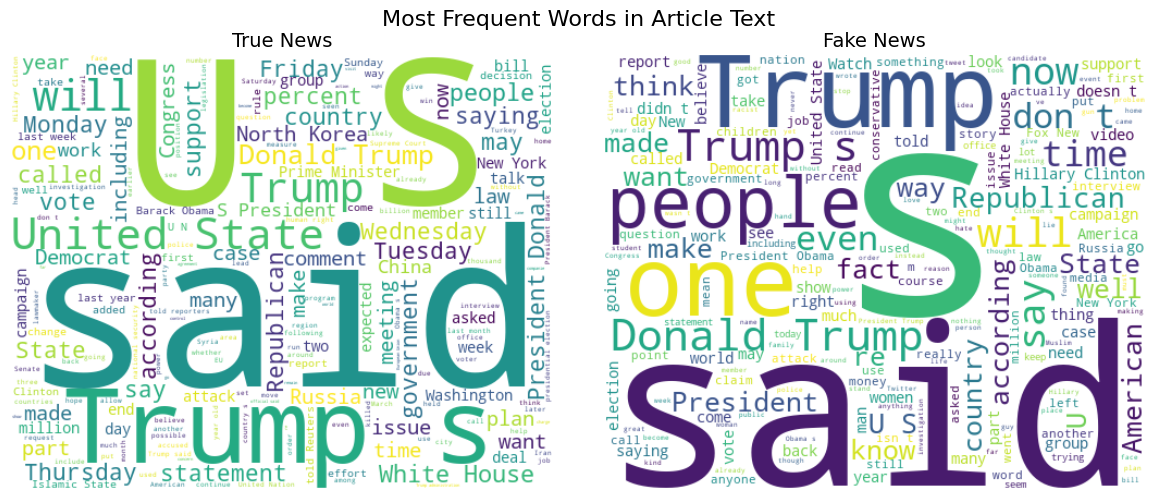

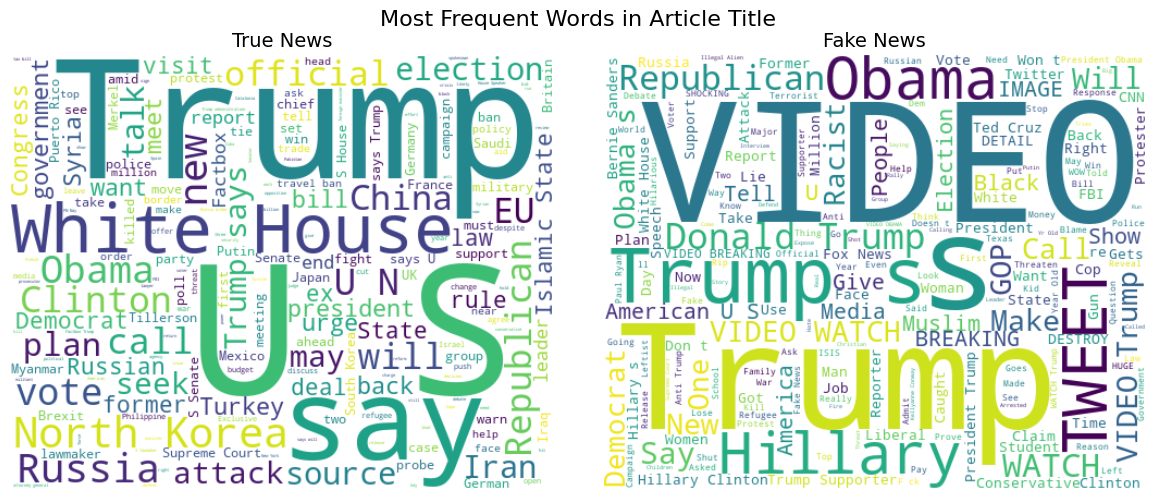

In [23]:
plot_wordclouds(original_train, "text")
plot_wordclouds(original_train, "title")

- As already noted, this dataset is highly political, with frequent mentions of terms like Trump, United States, and White House.  
- Fake news titles are dominated by words like "tweet", "video", and "watch", reflecting attention-seeking reporting focused on engagement over substance.

### New Testing Dataset

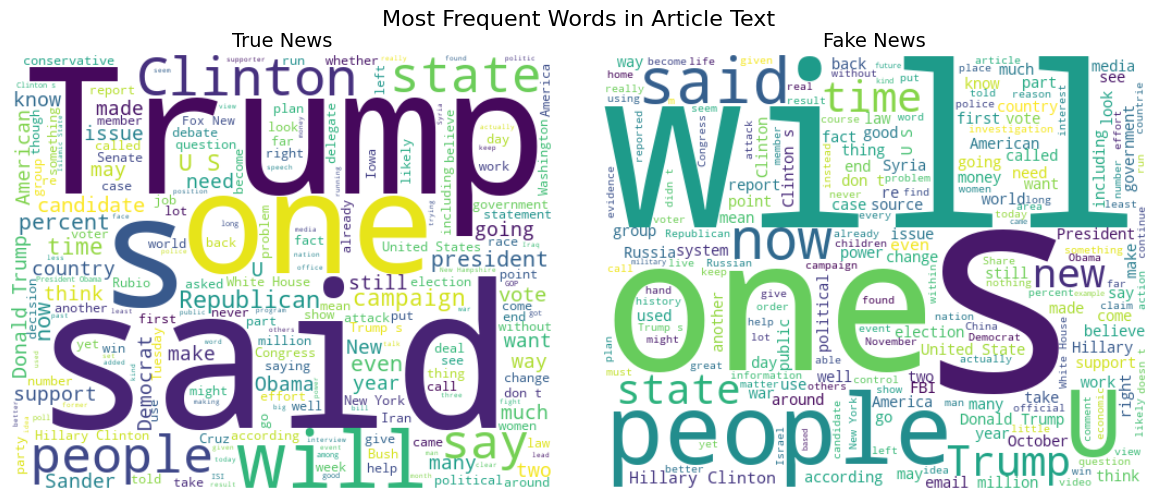

In [24]:
plot_wordclouds(new_test, "text")

- The subjects of the two datasets appear to be very similar as nearly the same dominant words are present in the new test set.

## Univariate Distributions

### Original Dataset

The dataset contains three structured features suitable for EDA: subject, date, and the true/false label. 

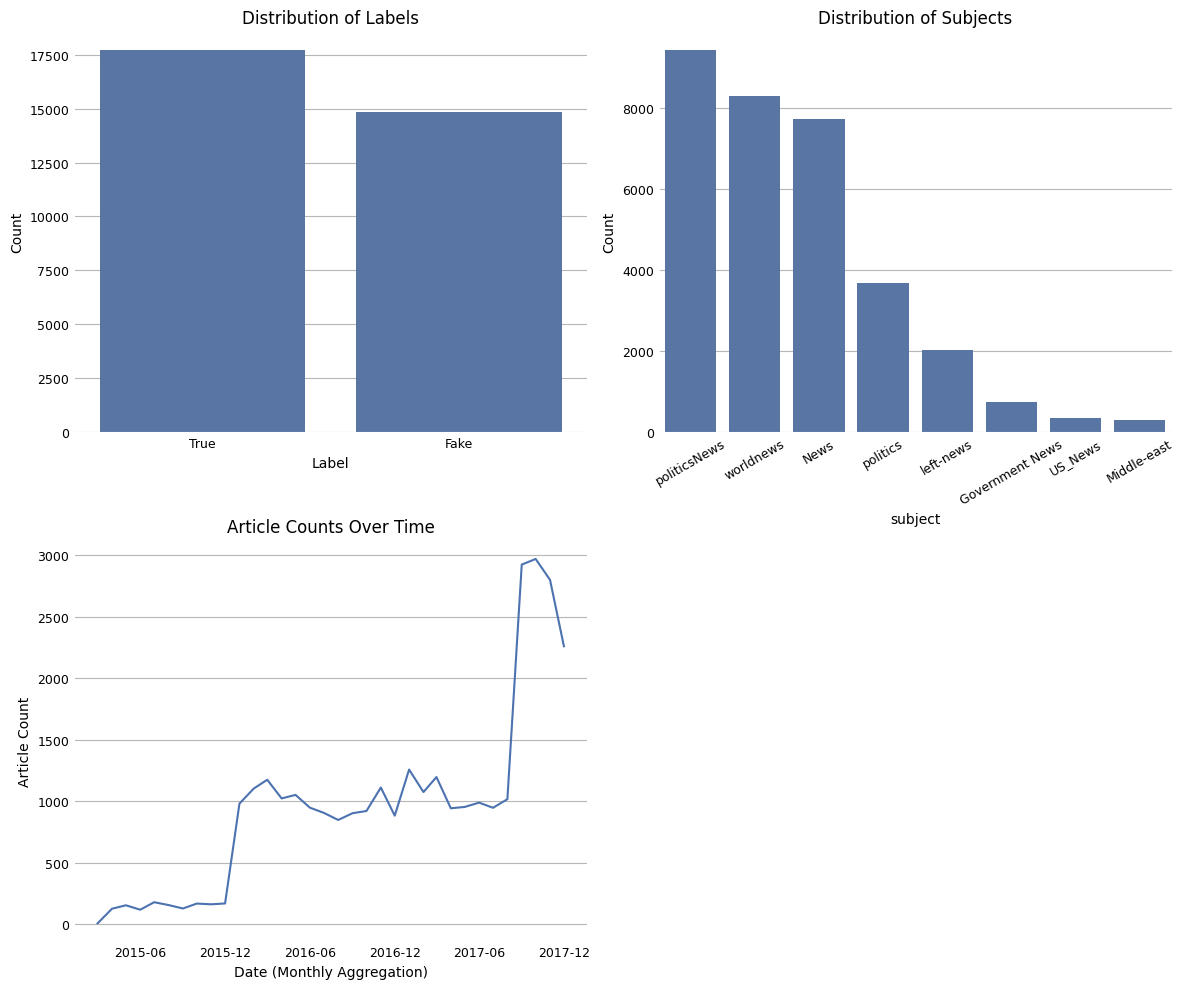

Accuracy if the model always predicts majority class "True": 0.54%


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.countplot(
    x=original_train["label"],
    order=original_train["label"].value_counts().index,
    ax=axes[0, 0],
    zorder=2,
)
axes[0, 0].set_xlabel("Label")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Distribution of Labels")

monthly_counts = original_train.groupby(original_train["date"].dt.to_period("M")).size()
monthly_counts.index = monthly_counts.index.to_timestamp()
axes[1, 0].plot(
    monthly_counts.index, monthly_counts.values, linestyle="-", marker="", zorder=2
)
axes[1, 0].set_xlabel("Date (Monthly Aggregation)")
axes[1, 0].set_ylabel("Article Count")
axes[1, 0].set_title("Article Counts Over Time")
axes[1, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

sns.countplot(
    x=original_train["subject"],
    order=original_train["subject"].value_counts().index,
    ax=axes[0, 1],
    zorder=2,
)
axes[0, 1].set_xlabel("subject")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("Distribution of Subjects")
axes[0, 1].tick_params(axis="x", rotation=30)

fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

class_counts = original_train["label"].value_counts()
majority_class = class_counts.idxmax()
majority_accuracy = class_counts.max() / class_counts.sum()
print(
    f"Accuracy if the model always predicts majority class \"{majority_class}\": {majority_accuracy:.2f}%"
)

- A few subjects account for the majority of articles.  
- The number of new articles increases over time, with two noticeable jumps suggesting either the addition of new sources or a shift in the volume of true or fake news.  
- There are slightly more true news articles, but the class imbalance is minor.

### New Testing Dataset

There is a single structured feature of label.

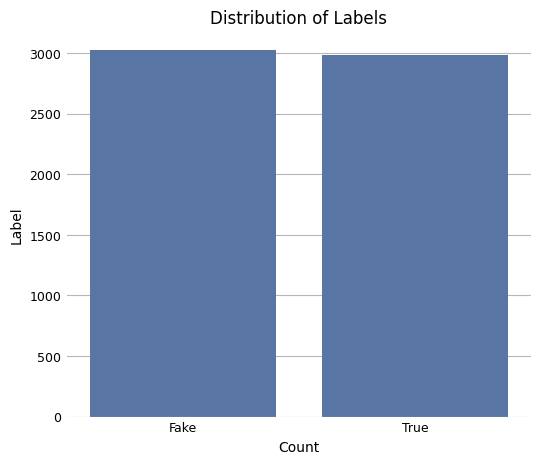

In [26]:
sns.countplot(x=new_test["label"], zorder=2)
plt.title("Distribution of Labels")
plt.xlabel("Count")
plt.ylabel("Label");

- The classes are balanced.

## Bivariate Distributions

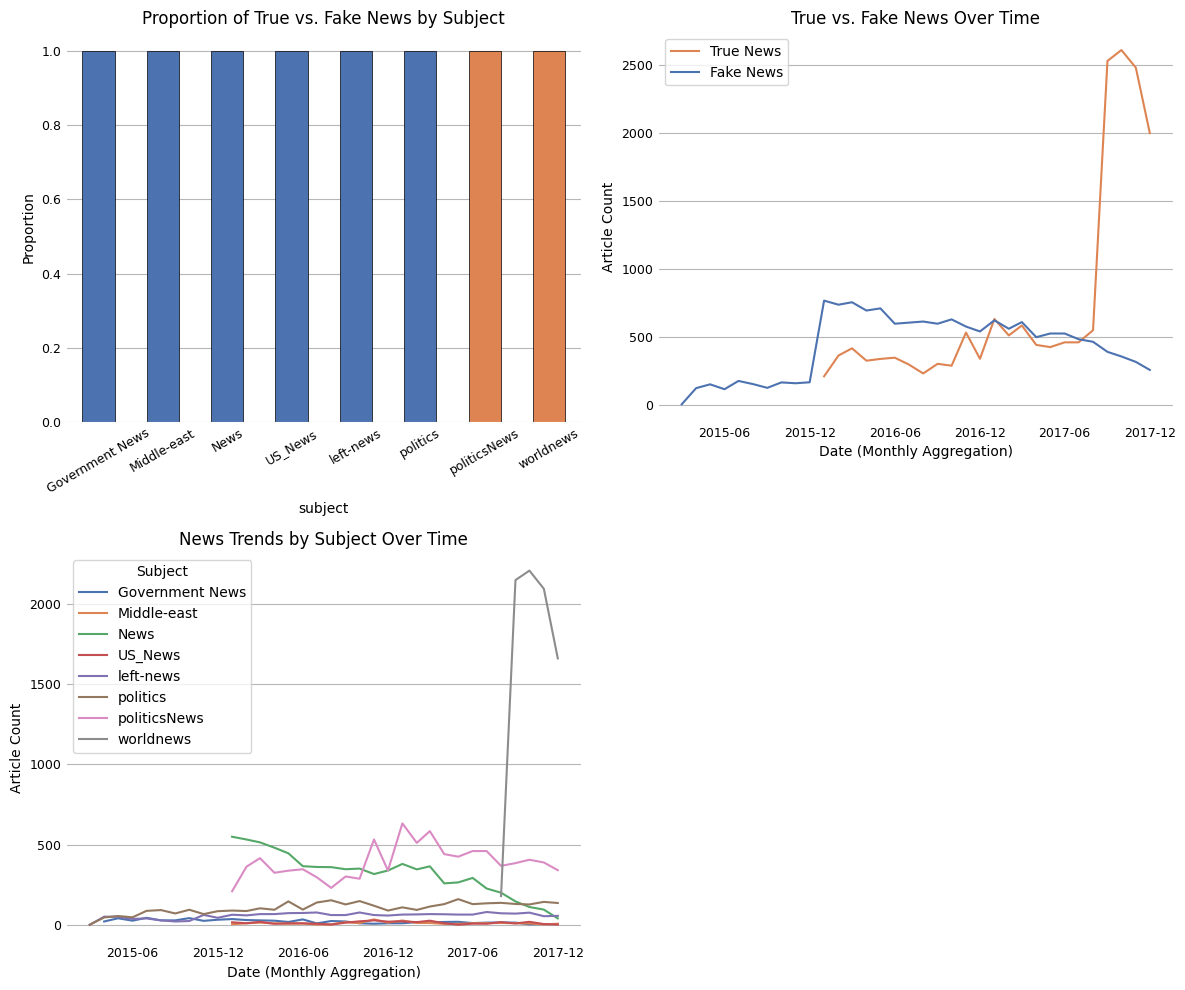

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

crosstab = pd.crosstab(
    original_train["subject"], original_train["label"], normalize="index"
)
crosstab.plot(
    kind="bar",
    stacked=True,
    ax=axes[0, 0],
    edgecolor="black",
    linewidth=0.5,
    zorder=2,
    color=["#4C72B0", "#DD8452"],
)
axes[0, 0].set_ylabel("Proportion")
axes[0, 0].set_title("Proportion of True vs. Fake News by Subject")
axes[0, 0].legend_.remove()
axes[0, 0].tick_params(axis="x", rotation=30)
axes[0, 0].xaxis.grid(False)

monthly_counts = (
    original_train.groupby([original_train["date"].dt.to_period("M"), "label"])
    .size()
    .unstack()
)
monthly_counts.index = monthly_counts.index.to_timestamp()
axes[0, 1].plot(
    monthly_counts.index,
    monthly_counts["True"],
    linestyle="-",
    marker="",
    color="#DD8452",
    label="True News",
)
axes[0, 1].plot(
    monthly_counts.index,
    monthly_counts["Fake"],
    linestyle="-",
    marker="",
    color="#4C72B0",
    label="Fake News",
)

axes[0, 1].set_xlabel("Date (Monthly Aggregation)")
axes[0, 1].set_ylabel("Article Count")
axes[0, 1].set_title("True vs. Fake News Over Time")
axes[0, 1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[0, 1].legend()

subject_counts = (
    original_train.groupby([original_train["date"].dt.to_period("M"), "subject"])
    .size()
    .unstack()
)
subject_counts.index = subject_counts.index.to_timestamp()

for subject in subject_counts.columns:
    axes[1, 0].plot(
        subject_counts.index,
        subject_counts[subject],
        linestyle="-",
        marker="",
        label=subject,
    )

axes[1, 0].set_xlabel("Date (Monthly Aggregation)")
axes[1, 0].set_ylabel("Article Count")
axes[1, 0].set_title("News Trends by Subject Over Time")
axes[1, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[1, 0].legend(title="Subject")

fig.delaxes(axes[1, 1])
plt.tight_layout()

- All true news comes from the "politicsNews" and "worldnews" categories, while all other subjects are labeled as fake. This is a strange result, suggesting some underlying bias in the data.  
- In the first half of the year of data colection, there are no true articles. True news begins to appear when "politicsNews" is introduced, followed by another sharp increase when a new source of "worldnews" is added.
- Subject should not be added as a feature into the model, as it would introduce data leakage.  
- Date should also not be included, since it reflects when new sources were added to the dataset rather than a natural shift in news content over time. Also, all dates are in the past, and including them would not generalize to current or future data.

## Sequence Lengths

### Original Dataset

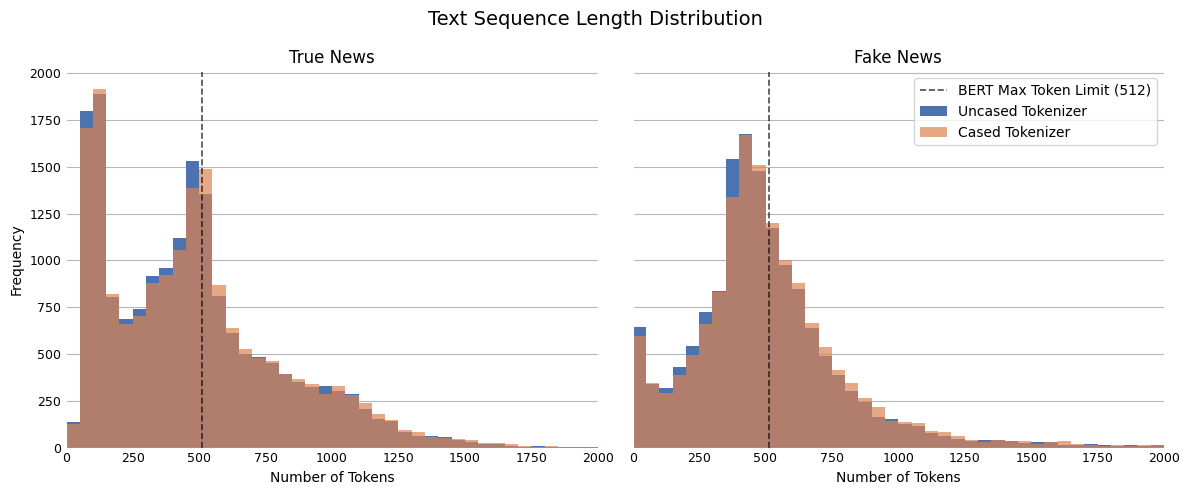

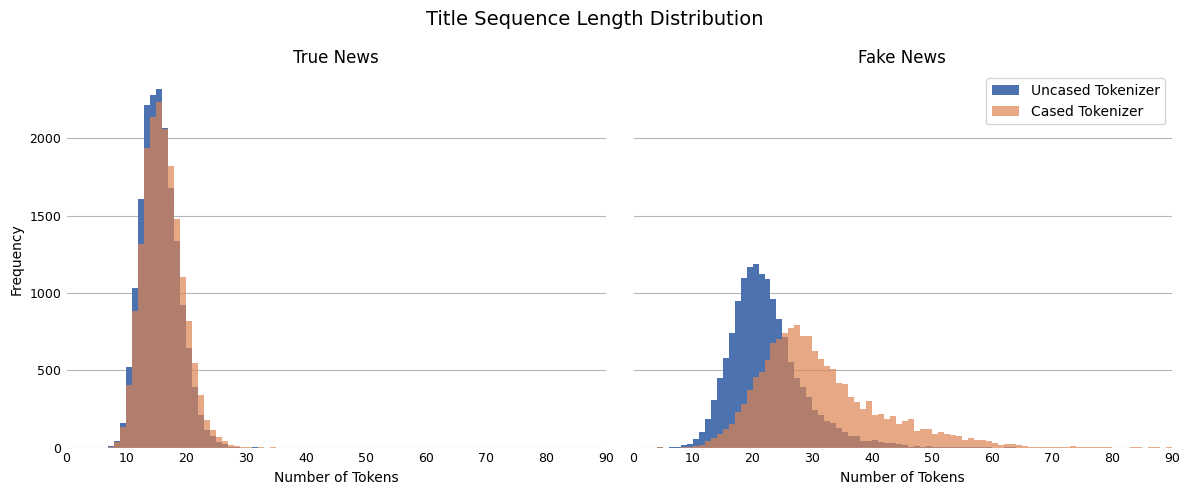

Proportion of text sequences exceeding 512 tokens:

- True News (Uncased Tokenizer): 37.73%
- True News (Cased Tokenizer):   40.01%
- Fake News (Uncased Tokenizer): 40.50%
- Fake News (Cased Tokenizer):   43.07%


In [28]:
tokenizer_uncased = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", model_max_length=100000
)
tokenizer_cased = DistilBertTokenizer.from_pretrained(
    "distilbert-base-cased", model_max_length=100000
)
token_lengths_text = compute_token_lengths(
    original_train, "text", tokenizer_uncased, tokenizer_cased
)
token_lengths_title = compute_token_lengths(
    original_train, "title", tokenizer_uncased, tokenizer_cased
)
true_text = token_lengths_text["True"]
fake_text = token_lengths_text["Fake"]
true_title = token_lengths_title["True"]
fake_title = token_lengths_title["Fake"]

text_bins = np.arange(0, 2001, 50)
title_bins = np.arange(0, 91, 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.suptitle("Text Sequence Length Distribution", fontsize=14)

sns.histplot(
    true_text["uncased"],
    bins=text_bins,
    color="#4C72B0",
    label="Uncased Tokenizer",
    ax=axes[0],
    alpha=1,
    zorder=2,
    edgecolor=None,
)
sns.histplot(
    true_text["cased"],
    bins=text_bins,
    color="#DD8452",
    label="Cased Tokenizer",
    ax=axes[0],
    alpha=0.7,
    zorder=2,
    edgecolor=None,
)
axes[0].axvline(
    512,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label="BERT Max Token Limit (512)",
    alpha=0.7,
)
axes[0].set_xlim(0, 2000)
axes[0].set_title("True News")
axes[0].set_xlabel("Number of Tokens")
axes[0].set_ylabel("Frequency")

sns.histplot(
    fake_text["uncased"],
    bins=text_bins,
    color="#4C72B0",
    label="Uncased Tokenizer",
    ax=axes[1],
    alpha=1,
    zorder=2,
    edgecolor=None,
)
sns.histplot(
    fake_text["cased"],
    bins=text_bins,
    color="#DD8452",
    label="Cased Tokenizer",
    ax=axes[1],
    alpha=0.7,
    zorder=2,
    edgecolor=None,
)
axes[1].axvline(
    512,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label="BERT Max Token Limit (512)",
    alpha=0.7,
)
axes[1].set_xlim(0, 2000)
axes[1].set_title("Fake News")
axes[1].set_xlabel("Number of Tokens")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.suptitle("Title Sequence Length Distribution", fontsize=14)

sns.histplot(
    true_title["uncased"],
    bins=title_bins,
    color="#4C72B0",
    label="Uncased Tokenizer",
    ax=axes[0],
    alpha=1,
    zorder=2,
    edgecolor=None,
)
sns.histplot(
    true_title["cased"],
    bins=title_bins,
    color="#DD8452",
    label="Cased Tokenizer",
    ax=axes[0],
    alpha=0.7,
    zorder=2,
    edgecolor=None,
)
axes[0].set_xlim(0, 90)
axes[0].set_title("True News")
axes[0].set_xlabel("Number of Tokens")
axes[0].set_ylabel("Frequency")

sns.histplot(
    fake_title["uncased"],
    bins=title_bins,
    color="#4C72B0",
    label="Uncased Tokenizer",
    ax=axes[1],
    alpha=1,
    zorder=2,
    edgecolor=None,
)
sns.histplot(
    fake_title["cased"],
    bins=title_bins,
    color="#DD8452",
    label="Cased Tokenizer",
    ax=axes[1],
    alpha=0.7,
    zorder=2,
    edgecolor=None,
)
axes[1].set_title("Fake News")
axes[1].set_xlabel("Number of Tokens")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

prop_true_uncased = (true_text["uncased"] > 512).mean()
prop_true_cased = (true_text["cased"] > 512).mean()
prop_fake_uncased = (fake_text["uncased"] > 512).mean()
prop_fake_cased = (fake_text["cased"] > 512).mean()

print("Proportion of text sequences exceeding 512 tokens:\n")
print(f"- True News (Uncased Tokenizer): {prop_true_uncased:.2%}")
print(f"- True News (Cased Tokenizer):   {prop_true_cased:.2%}")
print(f"- Fake News (Uncased Tokenizer): {prop_fake_uncased:.2%}")
print(f"- Fake News (Cased Tokenizer):   {prop_fake_cased:.2%}")

- I will use the cased version of the BERT tokenizer. 40% of article texts exceed the BERT sequence limit, which will require truncation. 
- I will test different sequence limits to find the smallest input length that maintains the highest performance.  
- In article texts and titles labeled as true, there is little difference between the distributions of capitalized and non-capitalized words.  
- Fake news article titles stand out for having a high amount of capitalized text. This would be a predictive feature, but I find this pattern unexpected and am unsure if it would generalize well in a production environment.
- I will use the text as model input in sequence, but the title could be added if performance is not sufficient.

### New Testing Dataset

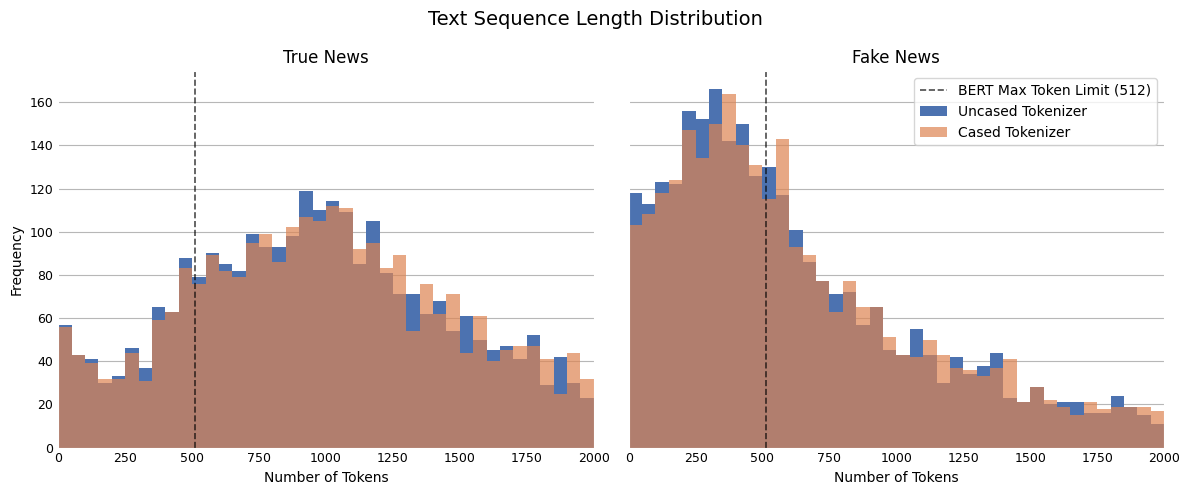

In [29]:
token_lengths_text = compute_token_lengths(
    new_test, "text", tokenizer_uncased, tokenizer_cased
)
token_lengths_title = compute_token_lengths(
    new_test, "title", tokenizer_uncased, tokenizer_cased
)
true_text = token_lengths_text["True"]
fake_text = token_lengths_text["Fake"]
true_title = token_lengths_title["True"]
fake_title = token_lengths_title["Fake"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.suptitle("Text Sequence Length Distribution", fontsize=14)

sns.histplot(
    true_text["uncased"],
    bins=text_bins,
    color="#4C72B0",
    label="Uncased Tokenizer",
    ax=axes[0],
    alpha=1,
    zorder=2,
    edgecolor=None,
)
sns.histplot(
    true_text["cased"],
    bins=text_bins,
    color="#DD8452",
    label="Cased Tokenizer",
    ax=axes[0],
    alpha=0.7,
    zorder=2,
    edgecolor=None,
)
axes[0].axvline(
    512,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label="BERT Max Token Limit (512)",
    alpha=0.7,
)
axes[0].set_xlim(0, 2000)
axes[0].set_title("True News")
axes[0].set_xlabel("Number of Tokens")
axes[0].set_ylabel("Frequency")

sns.histplot(
    fake_text["uncased"],
    bins=text_bins,
    color="#4C72B0",
    label="Uncased Tokenizer",
    ax=axes[1],
    alpha=1,
    zorder=2,
    edgecolor=None,
)
sns.histplot(
    fake_text["cased"],
    bins=text_bins,
    color="#DD8452",
    label="Cased Tokenizer",
    ax=axes[1],
    alpha=0.7,
    zorder=2,
    edgecolor=None,
)
axes[1].axvline(
    512,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label="BERT Max Token Limit (512)",
    alpha=0.7,
)
axes[1].set_xlim(0, 2000)
axes[1].set_title("Fake News")
axes[1].set_xlabel("Number of Tokens")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

- The content is longer than in the original dataset, and most of it will be discarded after tokenization due to truncation limits.

## Summary

- The target variable is slightly imbalanced, with more true than fake articles.  
- All true articles come from "politicsNews" and "worldnews", while all other subjects are labeled as fake. This is an unusual pattern that may indicate issues with how the data was collected or labeled, though the exact cause is unclear.
- 40% of texts exceed the BERT token limit and will need to be truncated. I will use the cased version of the BERT tokenizer.
- I will test different sequence limits to find the smallest input length that maintains the highest performance.  
- Cased and uncased token distributions are similar overall, except for fake news titles, which are much moew capitalized.
- New dataset has balance labels with longer text lenghts. It's subject matter seems to be very similar to the original data.
- Subject and date should be excluded due to data leakage and because they reflect past-specific patterns that would not generalize to future data.
- If the model underperformes based on text, title can be included in the sequence.

# Heuristic Rule Predictions

The main objectives for this part of the notebook:

- Identify predictive lexical features like keywords or phrases.
- Use these heuristic rules to establish a baseline model.

## Heuristic Features

I will recalculate the most common n-grams for each label and compare them. Unlike the earlier calculation, this time I will focus on high-frequency patterns, as small differences in rare n-grams make weak classifiers. I will also use TF-IDF to identify the strongest unigrams for each label.

In [30]:
# N-grams (2–3) - raw frequency
fake_ngrams = get_ngram_freq(
    original_train[original_train["label"] == "Fake"]["text"], top_n=40
)
true_ngrams = get_ngram_freq(
    original_train[original_train["label"] == "True"]["text"], top_n=40
)
fake_only_ngrams = fake_ngrams[~fake_ngrams.index.isin(true_ngrams.index)].sort_values(
    ascending=False
)
true_only_ngrams = true_ngrams[~true_ngrams.index.isin(fake_ngrams.index)].sort_values(
    ascending=False
)

# Unigrams - mean TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf_matrix = vectorizer.fit_transform(original_train["text"])
labels = (original_train["label"] == "True").astype(int).to_numpy()

fake_tfidf_mean = tfidf_matrix[labels == 0].mean(axis=0)
true_tfidf_mean = tfidf_matrix[labels == 1].mean(axis=0)

tfidf_scores = pd.DataFrame(
    {
        "Fake": np.array(fake_tfidf_mean).flatten(),
        "True": np.array(true_tfidf_mean).flatten(),
    },
    index=vectorizer.get_feature_names_out(),
)
tfidf_scores["Difference"] = np.abs(tfidf_scores["Fake"] - tfidf_scores["True"])
tfidf_scores = tfidf_scores.sort_values(by="Difference", ascending=False)

fake_stronger = tfidf_scores[tfidf_scores["Fake"] > tfidf_scores["True"]].index.tolist()
true_stronger = tfidf_scores[tfidf_scores["True"] > tfidf_scores["Fake"]].index.tolist()

print_ngrams(
    "Fake News – Frequent n-grams mostly absent from True News:",
    fake_only_ngrams.index.tolist(),
    max_ngrams=50,
)
print_ngrams(
    "Fake News – Top unigrams with higher TF-IDF than in True News:",
    fake_stronger,
    max_ngrams=50,
)
print_ngrams(
    "True News – Frequent n-grams mostly absent from Fake News:",
    true_only_ngrams.index.tolist(),
    max_ngrams=50,
)
print_ngrams(
    "True News – Top unigrams with higher TF-IDF than in Fake News:",
    true_stronger,
    max_ngrams=50,
)


Fake News – Frequent n-grams mostly absent from True News:
president obama, fox news, president trump, trump realdonaldtrump, donald trump realdonaldtrump, republican party, ted cruz, fake news, 2017 realdonaldtrump, american people, social media, bernie sanders, york times, new york times, right wing
washington post, trump supporters, law enforcement, obama administration, don know, lives matter, black lives, presidential candidate, president united, president united states

Fake News – Top unigrams with higher TF-IDF than in True News:
trump, just, like, hillary, clinton, video, know, america, people, watch, obama, black, don, right, gop
really, fact, didn, fox, women, man, doesn, going, actually, racist, donald, thing, ve, think, time
got, american, way, isn, woman, americans, things, realdonaldtrump, read, cnn, gun, news, media, went, hate
great, let, want, says, story

True News – Frequent n-grams mostly absent from Fake News:
president donald, president donald trump, north korea

## Setting a Baseline

To create a simple rule-based baseline, I defined two sets of n-grams: one commonly found in fake news and another in true news. Each news article is scanned for the presence of these patterns.

- If the text contains any fake n-gram or no true n-gram, it is labeled as "Fake".
- If the text contains at least one true n-gram and no fake n-gram, it is labeled as "True".

I iteratively tested different sets of n-grams, stopping when they started to have minimal or negative impact or accuracy.

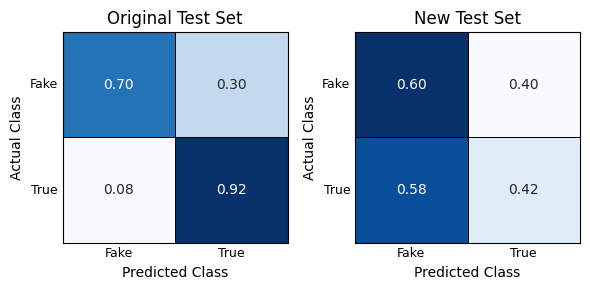

Results on original test dataset:
Accuracy of heuristic rules: 82.23%

Results on new test dataset:
Accuracy of heuristic rules: 51.09%


In [31]:
# Define patterns and classifier
fake_ngrams = ["president obama", "fox news", "president trump", "video"]
true_ngrams = [
    "president donald",
    "said statement",
    "islamic state",
    "president barack",
    "house representatives",
    "human rights",
    "united nations",
    "official said",
    "european union",
    "presidential election",
    "saudi arabia",
    "president elect",
    "minister",
    "government",
    "china",
    "wednesday",
    "thursday",
    "monday",
    "friday",
    "tuesday",
    "reuters",
]

fake_pattern = create_pattern(fake_ngrams)
true_pattern = create_pattern(true_ngrams)
classify_text = true_false_classifier(fake_pattern, true_pattern)

# Evaluate on both datasets
news_heuristic_predictions = original_test.copy()
news_heuristic_predictions["predicted_label"] = news_heuristic_predictions[
    "text"
].apply(classify_text)
new_news_eval = new_news.copy()
new_news_eval["predicted_label"] = new_news_eval["text"].apply(classify_text)
accuracy_train = (
    news_heuristic_predictions["predicted_label"] == news_heuristic_predictions["label"]
).mean()
accuracy_new = (new_news_eval["predicted_label"] == new_news_eval["label"]).mean()

# Plot matrixes
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_confusion_matrix(
    news_heuristic_predictions["label"],
    news_heuristic_predictions["predicted_label"],
    title="Original Test Set",
    ax=axes[0],
)
plot_confusion_matrix(
    new_news_eval["label"],
    new_news_eval["predicted_label"],
    title="New Test Set",
    ax=axes[1],
)
plt.tight_layout()
plt.show()

print("Results on original test dataset:")
print(f"Accuracy of heuristic rules: {accuracy_train:.2%}")
print("\nResults on new test dataset:")
print(f"Accuracy of heuristic rules: {accuracy_new:.2%}")

Heuristic rules on the original test data:

- The baseline rule-based prediction reached 82% accuracy, with weaker performance on fake news. Removing some true news rules could improve balance, but would reduce overall accuracy due to the dataset having more True news.  
- True news n-grams generally reflect formal reporting language, official titles, geopolitical terms, and structured event references—consistent with objective news writing. Examples include "prime minister", "united nations", and "official said".  
- True news n-grams were likely easier to identify because they reflect the consistent reporting style of Reuters, the sole source of all true-labeled articles. In contrast, fake news likely comes from multiple sources with varying styles, making their patterns more diverse and harder to isolate.

Heuristic rules on the new test data:

- On the new test set, accuracy dropped to 51%—close to random guessing. This suggests that the available patterns do not generalize well, which is not surprising.  
- However, the rules are at least not systematically biased in the wrong direction, which would have resulted in accuracy below 50%.

# Machine Learning

The main objectives for this part of the notebook are:

- Build a model using features extracted with TF-IDF.  
- Compare performance on the two different test datasets.
- Analyze the model’s performance.

## Training and Tuning on TF-IDF Features

The training data is split into training and validation sets. A TF-IDF vectorizer transforms the text into 2,000 features, and multiple models are evaluated using PR AUC. The best-performing model is selected and optimized using grid search to find the near-optimal number of features and n-gram range. A final model is then retrained on the full training set using the selected hyperparameters. Since this operation was repeated several times, the hyperparameter values have already been narrowed down significantly in the code to avoid long excecution times.

All evaluations in this project use the default classification threshold of 0.5, which will not be adjusted. The validation set is created as 20% of the remaining 85% after the test split. This means the validation set is 17% of the original unsplit dataset.

In [32]:
warnings.filterwarnings("ignore", message="X does not have valid feature names")
X_full = original_train["text"]
y_full = (original_train["label"] == "True").astype(int).values
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=5, stratify=y_full
)

models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", random_state=5),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=5),
    "XGBoost": XGBClassifier(
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), random_state=5
    ),
    "LightGBM": LGBMClassifier(class_weight="balanced", random_state=5, verbose=-1),
}

number_of_features = 2000
vectorizer = TfidfVectorizer(
    stop_words="english", max_features=number_of_features, ngram_range=(1, 2)
)
X_train_ml = vectorizer.fit_transform(X_train)
X_val_ml = vectorizer.transform(X_val)

results_val = []
for name, model in models.items():
    model.fit(X_train_ml, y_train)
    y_pred = model.predict(X_val_ml)
    y_prob = model.predict_proba(X_val_ml)[:, 1]
    results_val.append(evaluate_model(y_val, y_pred, y_prob, name))

results_val_df = (
    pd.DataFrame(results_val).sort_values("pr_auc", ascending=False).round(4)
)
print(f"Model selection based on {number_of_features} features:")
display(results_val_df)

best_model_name = results_val_df.iloc[0]["Model"]
best_model = models[best_model_name]
print(f"Best model based on pr_auc: {best_model_name}")

pipe = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2))),
        ("clf", type(best_model)(**best_model.get_params())),
    ]
)

param_grid = {
    "tfidf__max_features": [19000, 20000, 21000],
    "tfidf__ngram_range": [(1, 2)],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=0,
)

grid.fit(X_full, y_full)
final_pipe = grid.best_estimator_
final_pipe.fit(X_full, y_full)

X_original_test_ml = final_pipe.named_steps["tfidf"].transform(original_test["text"])
y_original_test = (original_test["label"] == "True").astype(int).values
y_pred_original_test = final_pipe.named_steps["clf"].predict(X_original_test_ml)
y_prob_original_test = final_pipe.named_steps["clf"].predict_proba(X_original_test_ml)[
    :, 1
]
X_new_ml = final_pipe.named_steps["tfidf"].transform(new_news["text"])
y_new = (new_news["label"] == "True").astype(int).values
y_pred_new = final_pipe.named_steps["clf"].predict(X_new_ml)
y_prob_new = final_pipe.named_steps["clf"].predict_proba(X_new_ml)[:, 1]

print("Best parameters:", grid.best_params_)
print("Best PR AUC (CV average):", round(grid.best_score_, 4))

Model selection based on 2000 features:


,Model,pr_auc,roc_auc,accuracy,f1_fake,f1_true,precision_fake,precision_true,recall_fake,recall_true
3,LightGBM,0.9976,0.9972,0.9760,0.9736,0.9780,0.9769,0.9753,0.9703,0.9808
2,XGBoost,0.9970,0.9965,0.9733,0.9705,0.9755,0.9761,0.9709,0.9649,0.9802
0,LogisticRegression,0.9968,0.9962,0.9759,0.9734,0.9779,0.9785,0.9737,0.9683,0.9822
1,RandomForest,0.9959,0.9953,0.9685,0.9651,0.9713,0.9749,0.9633,0.9555,0.9794


Best model based on pr_auc: LightGBM
Best parameters: {'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Best PR AUC (CV average): 0.998


- LightGBM is the best-performing model, reaching pr_auc of 0.998 and accuracy of 97,6% on the validation data, well above the 82% heuristic baseline.  
- On the original test set, it's easy to achieve near-perfect accuracy and PR AUC with around 300 features; even 50 features are enough to reach a PR AUC of 0.975.  
- Unigrams alone and unigrams combined with bigrams yield nearly identical results.

## Performance Evaluation

,Model,pr_auc,roc_auc,accuracy,f1_fake,f1_true,precision_fake,precision_true,recall_fake,recall_true
0,Original Test Set,0.9990,0.9990,0.9864,0.9849,0.9876,0.9969,0.9780,0.9733,0.9974
1,New Test Set,0.5975,0.6331,0.5348,0.6578,0.2740,0.5182,0.6393,0.9003,0.1744


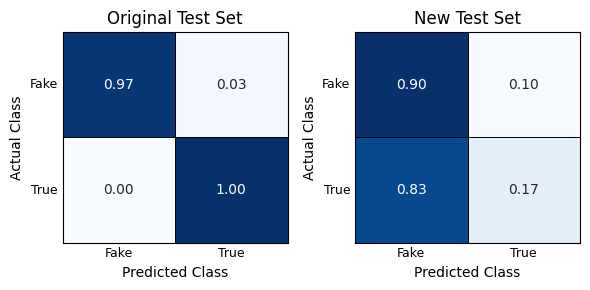

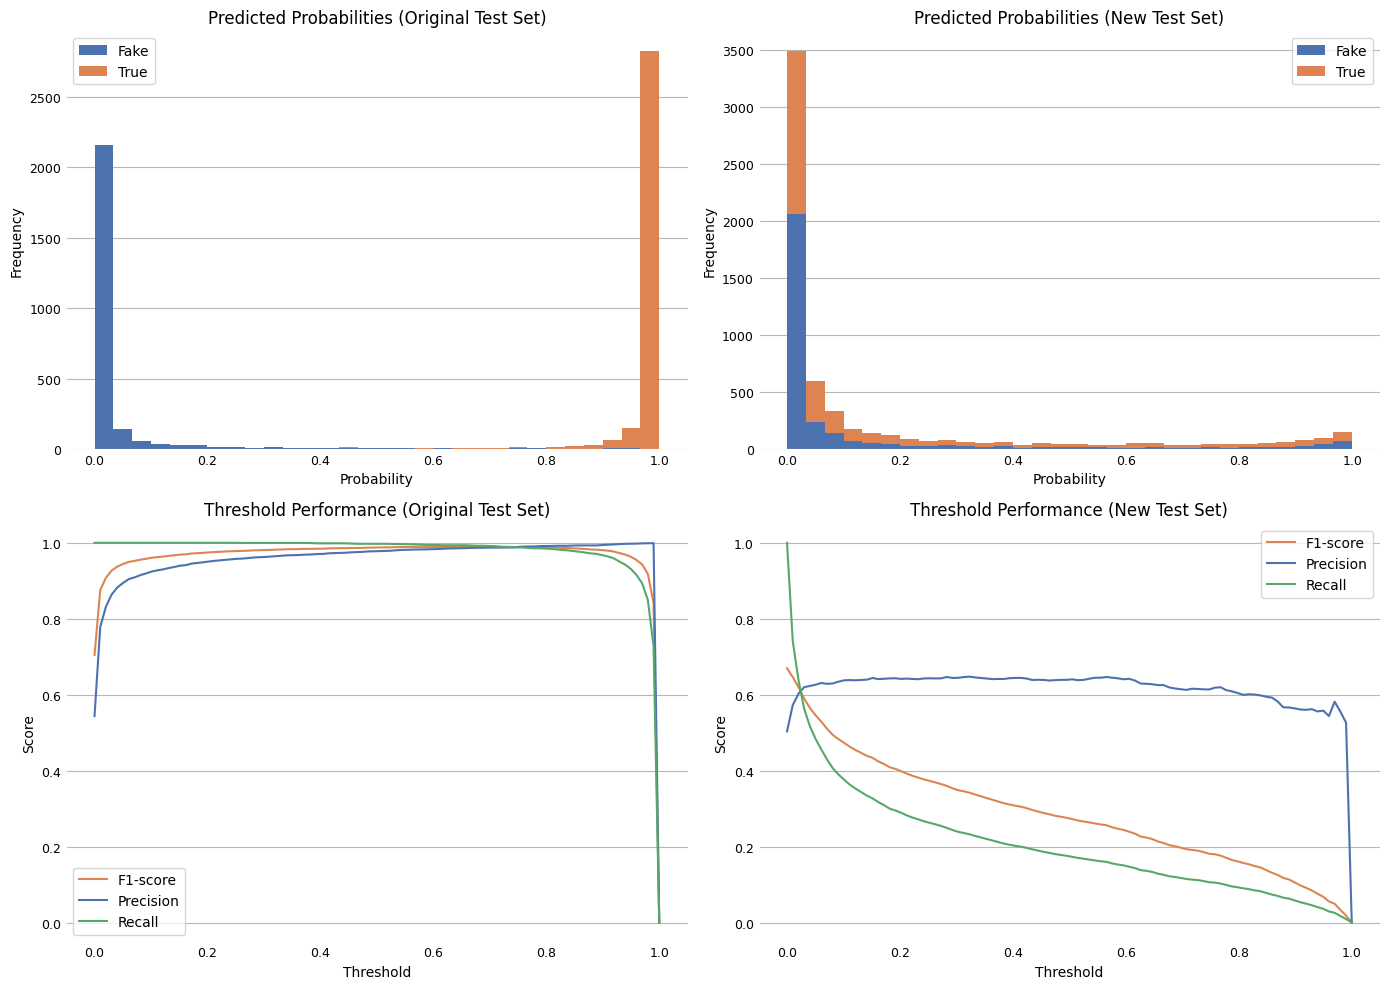

In [33]:
# Evaluation metrics
result_test = evaluate_model(
    y_original_test,
    y_pred_original_test,
    y_prob_original_test,
    model_name="Original Test Set",
)
result_new = evaluate_model(y_new, y_pred_new, y_prob_new, model_name="New Test Set")
combined_results = pd.DataFrame([result_test, result_new]).round(4)
display(combined_results)

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plot_confusion_matrix(
    original_test["label"],
    ["True" if p else "Fake" for p in y_pred_original_test],
    title="Original Test Set",
    ax=axes[0],
)
plot_confusion_matrix(
    new_news["label"],
    ["True" if p else "Fake" for p in y_pred_new],
    title="New Test Set",
    ax=axes[1],
)
plt.tight_layout()
plt.show()

# Predicted probabilities
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(
    [
        y_prob_original_test[y_original_test == 0],
        y_prob_original_test[y_original_test == 1],
    ],
    stacked=True,
    bins=30,
    color=["#4C72B0", "#DD8452"],
    label=["Fake", "True"],
    zorder=2,
)
axes[0, 0].set_title("Predicted Probabilities (Original Test Set)")
axes[0, 0].set_xlabel("Probability")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()

axes[0, 1].hist(
    [y_prob_new[y_new == 0], y_prob_new[y_new == 1]],
    stacked=True,
    bins=30,
    color=["#4C72B0", "#DD8452"],
    label=["Fake", "True"],
    zorder=2,
)
axes[0, 1].set_title("Predicted Probabilities (New Test Set)")
axes[0, 1].set_xlabel("Probability")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()

# Threshold performance
thresholds = np.linspace(0, 1, 100)
f1_test = [
    f1_score(y_original_test, y_prob_original_test >= t, zero_division=0)
    for t in thresholds
]
prec_test = [
    precision_score(y_original_test, y_prob_original_test >= t, zero_division=0)
    for t in thresholds
]
rec_test = [
    recall_score(y_original_test, y_prob_original_test >= t, zero_division=0)
    for t in thresholds
]

f1_new = [f1_score(y_new, y_prob_new >= t, zero_division=0) for t in thresholds]
prec_new = [
    precision_score(y_new, y_prob_new >= t, zero_division=0) for t in thresholds
]
rec_new = [recall_score(y_new, y_prob_new >= t, zero_division=0) for t in thresholds]

axes[1, 0].plot(thresholds, f1_test, label="F1-score", color="#DD8452", zorder=2)
axes[1, 0].plot(thresholds, prec_test, label="Precision", color="#4C72B0", zorder=2)
axes[1, 0].plot(thresholds, rec_test, label="Recall", color="#55A868", zorder=2)
axes[1, 0].set_title("Threshold Performance (Original Test Set)")
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("Score")
axes[1, 0].legend()

axes[1, 1].plot(thresholds, f1_new, label="F1-score", color="#DD8452", zorder=2)
axes[1, 1].plot(thresholds, prec_new, label="Precision", color="#4C72B0", zorder=2)
axes[1, 1].plot(thresholds, rec_new, label="Recall", color="#55A868", zorder=2)
axes[1, 1].set_title("Threshold Performance (New Test Set)")
axes[1, 1].set_xlabel("Threshold")
axes[1, 1].set_ylabel("Score")
axes[1, 1].legend()

plt.tight_layout()

- The model performs exceptionally well on the original test set, achieving a PR AUC of 0.9990 and an accuracy of 0.9864.
- As expected, performance on the new test set—which better reflects generalizability—drops to 53% accuracy, only around 2% better than the heuristic and majority-class baselines.  
- The model struggles with predicting the positive class on the new test set, with most predicted probabilities falling far from the correct values.
- On the new test set, using more than 120 features leads to significant overfitting.

## SHAP Analysis

100%|===================| 5740/5741 [01:25<00:00]        

SHAP plot for the original test dataset:


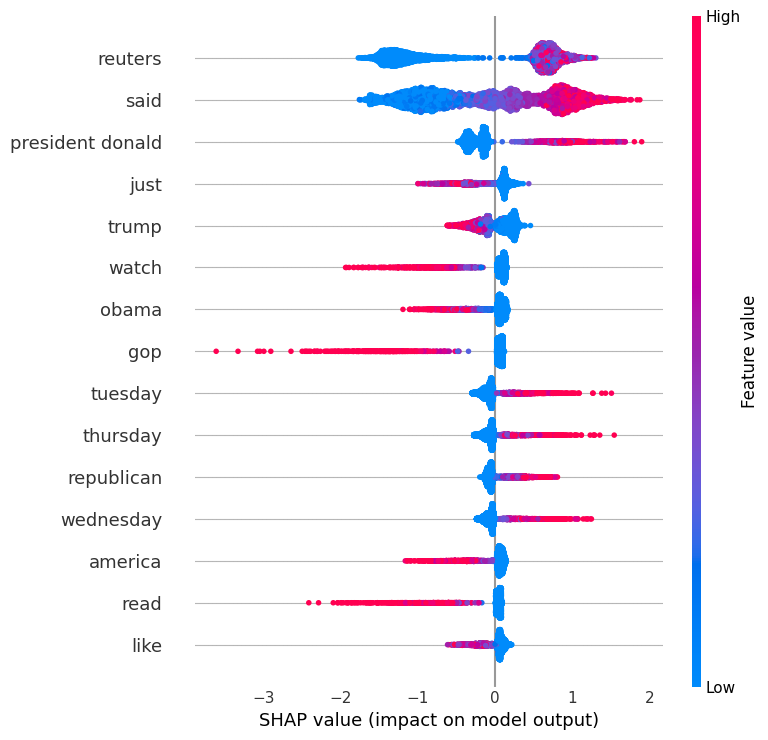

 99%|===================| 5964/6011 [01:29<00:00]        

SHAP plot for the new test dataset:


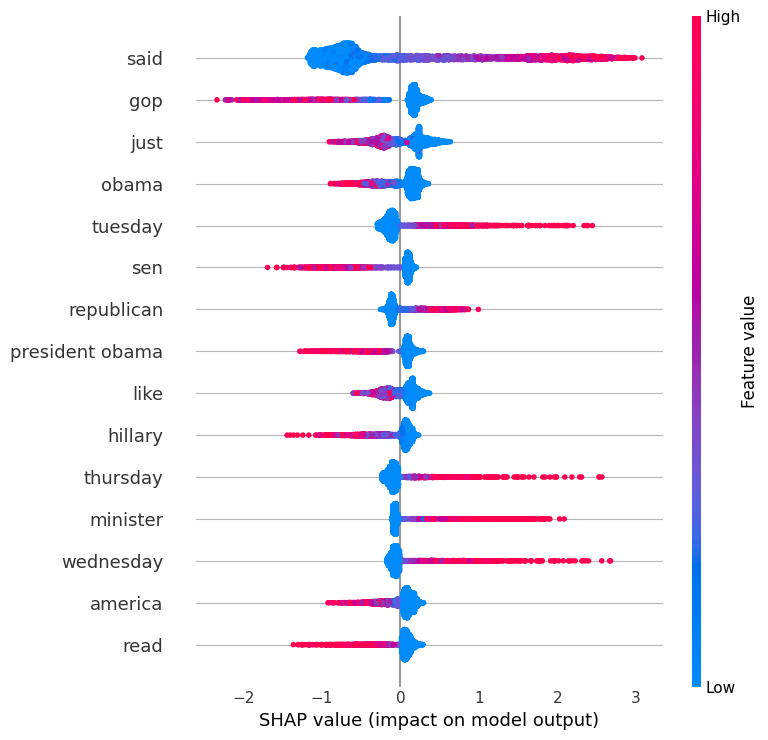

In [34]:
vectorizer = final_pipe.named_steps["tfidf"]
classifier = final_pipe.named_steps["clf"]
feature_names = vectorizer.get_feature_names_out()

X_test_dense = vectorizer.transform(original_test["text"]).toarray()
explainer = shap.Explainer(classifier, X_test_dense, feature_names=feature_names)
shap_values = explainer(X_test_dense)
print("SHAP plot for the original test dataset:")
shap.summary_plot(
    shap_values, X_test_dense, feature_names=feature_names, max_display=15
)

X_new_dense = vectorizer.transform(new_test["text"]).toarray()
explainer = shap.Explainer(classifier, X_new_dense, feature_names=feature_names)
shap_values = explainer(X_new_dense)
print("SHAP plot for the new test dataset:")
shap.summary_plot(shap_values, X_new_dense, feature_names=feature_names, max_display=15)

- The original test set closely matches the training data and the new test set contains different vocabulary, which means different features than what the model was trained on. This is visible by the difference in top features ranking between the two sets in each feature. For example, one of the most important predictors of "said", was much more present in the original data.
- "Reuters" appeared at the top of the SHAP plot for the original test set, as the news agency often quotes itself in its articles. While some fake news also cite Reuters, making this not a case of data leakage, it may still be helpful to hide all named news agencies to prevent the model from relying too heavily on their names. Since the new dataset does not contain Reuters mentions, the word does not contribute to predictions there.

## Error Analysis

The analysis will focus on the original test data, as the performance drop on the new data is largely explained by the absence of useful words or their presence at different frequencies.

### Case Inspection

In [35]:
misclassified_indices = y_original_test != y_pred_original_test
misclassified_ml = original_test.iloc[misclassified_indices].copy()
misclassified_ml["true_label"] = y_original_test[misclassified_indices]
misclassified_ml["predicted_label"] = y_pred_original_test[misclassified_indices]
misclassified_ml.drop(columns=["label"], inplace=True)
preview_text(misclassified_ml, 800, 1, "start")
print("Total misclassified examples:", misclassified_ml.shape[0])

,title,text,subject,date,true_label,predicted_label
18084,IT BEGINS: KAMIKAZE DRONE Equipped With Bomb To Be Set Off By Remote Detonator Found In Stolen Truck…Could Be Used For Terror Attacks Against U.S. Targets,"This is a truly disturbing discovery and an unimaginable threat that needs to be taken very seriously by our government Mexican police discovered four men carting a kamikaze drone equipped with an IED and a remote detonator last week, in what analysts say is an example of cartels figuring out how to weaponizing UAVs.The disturbing development is a manifestation of something top American security chiefs warned Congress about earlier this year, when they said they feared terrorists would begin to use drones to attack targets within the U.S.Drug cartels had already been turning to drones to smuggle their product into the U.S., and had begun using IEDs in their turf struggles but now at least cartel appears to have put the two technologies together, according to Mexican reports analyzed by S",left-news,2017-10-24,0,1


Total misclassified examples: 78


- The errors mostly involve articles that appear typical for the label and are not mislabelings, such as the displayed example warning about globalist elites.

### Words Used to Make Predictions

Errors may come from less typical sources that use different phrasing and vocabulary, meaning that the key words the model relies on might be missing.

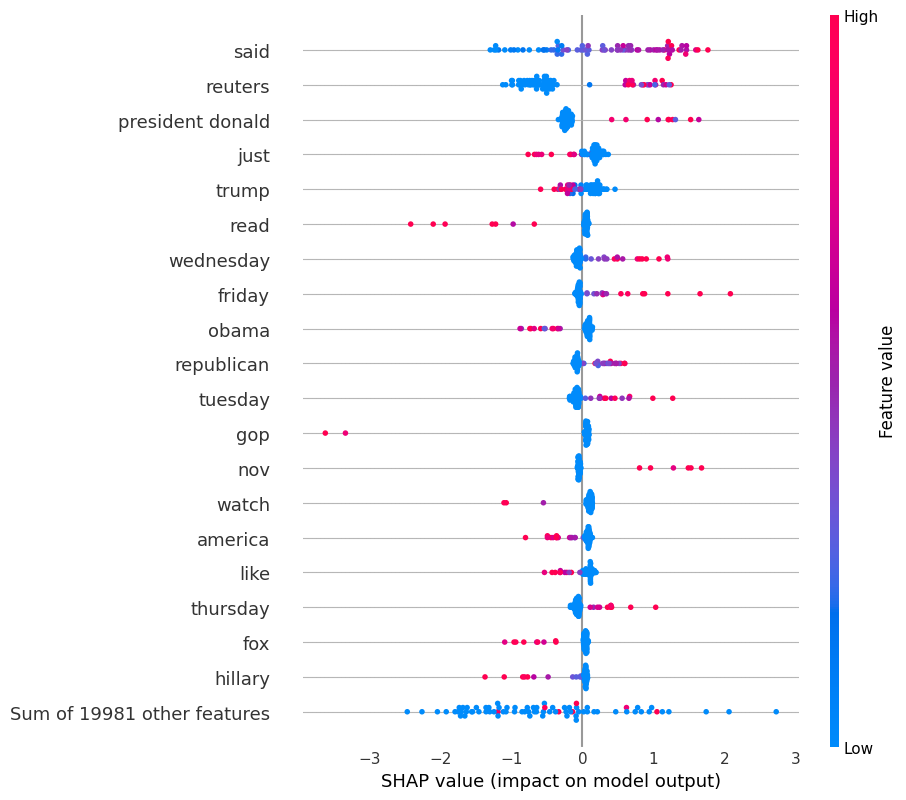

In [36]:
X_misclassified_texts = misclassified_ml["text"]
X_misclassified_vectorized = vectorizer.transform(X_misclassified_texts)
X_misclassified_dense = X_misclassified_vectorized.toarray()
X_background_dense = vectorizer.transform(original_test["text"]).toarray()
feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(classifier, X_background_dense, feature_names=feature_names)
shap_values = explainer(X_misclassified_dense)
shap.initjs()
shap.plots.beeswarm(shap_values, max_display=20)

- Feature importance is very similar to what was observed across the full dataset—the top features are the same ones used overall, indicating that the vocabulary in the misclassified examples does not differ significantly from the rest of the data.

### Individual Instance Analysis

I will check the features that have the strongest influence on individual predictions.

True Label: Fake | Predicted Label: True
Text:
Reasonable Americans expected never expected unbiased justice to be served by Eric Holder in a skirt Friday on MSNBC s  Morning Joe,  Bloomberg Politics Mark Halperin cited a  senior Justice
Department official  who said Attorney General Loretta Lynch will not recuse herself from the investigation into presumptive Democratic presidential nominee Hillary Clinton use of a private email
while secretary of state. Critics have called on Lynch to do so after holding a private meeting with her husband former President Bill Clinton earlier this week.Halperin also said the source does not
anticipate Ly...



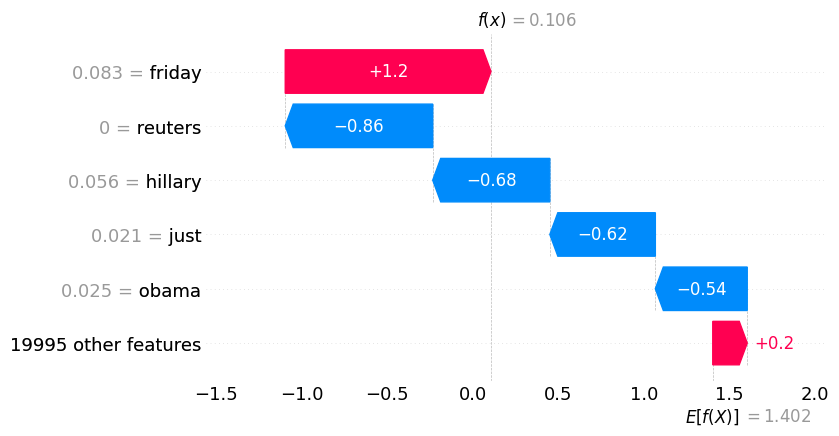

True Label: Fake | Predicted Label: True
Text:
Hurricane Irma, one of the most powerful Atlantic storms ever recorded, was responsible for the deaths of at least 102 people, 44 of whom were in the Caribbean. Of the fatalities recorded in the
mainland US, at least 50 were in Florida, 11 of which were due to the stifling conditions inside a South Florida nursing home after it lost power. Those 11 deaths could have possibly been avoided if
Republican Florida Governor Rick Scott had heeded the emergency calls he had received about the worsening conditions in the home.A criminal Probe has been opened into the tragedy at the Rehabilitation
Cente...



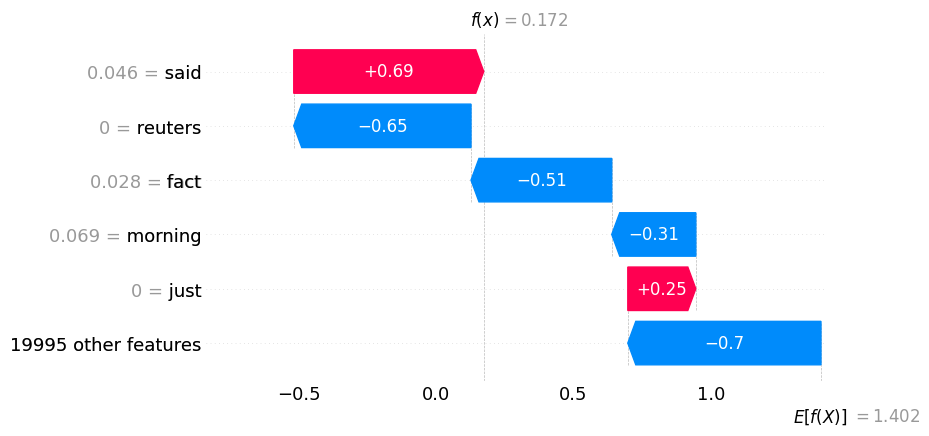

True Label: Fake | Predicted Label: True
Text:
Just suppose the play was cancelled because the school was using black actors. Would this be the only place you would see this story?A small, state college in northern Pennsylvania has canceled a
musical about a week before it was scheduled to open after the playwright objected to the use of white actors for South Asian characters.Clarion University had spent much of the year preparing to
stage the punk rock version of  Jesus in India,  by dramatist Lloyd Suh, which ran off-Broadway in 2013 and received favorable reviews.Suh, who owns the rights to the musical, sent an e-mail on Monday
to the ...



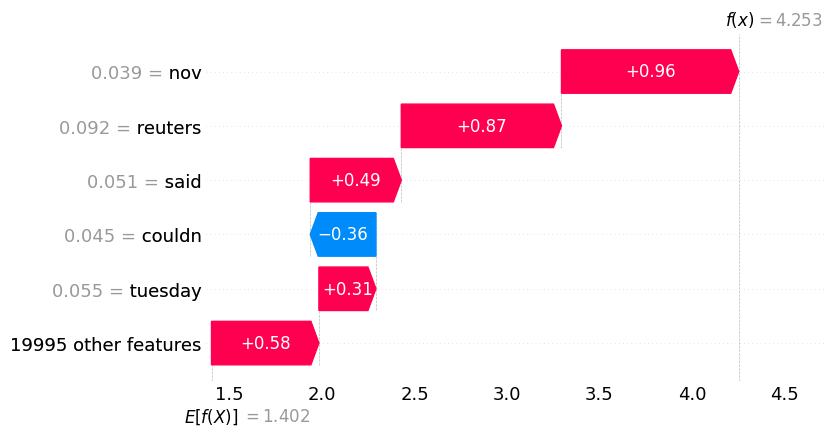

In [37]:
random.seed(5)
indices = random.sample(list(misclassified_ml.index), 3)

for idx in indices:
    shap_idx = misclassified_ml.index.get_loc(idx)
    row = misclassified_ml.loc[idx]

    true_label = "True" if row["true_label"] == 1 else "Fake"
    pred_label = "True" if row["predicted_label"] == 1 else "Fake"
    text = row["text"][:600] + "..."
    wrapped_text = "\n".join(textwrap.wrap(text, width=200))

    print(f"True Label: {true_label} | Predicted Label: {pred_label}")
    print(f"Text:\n{wrapped_text}\n")
    plt.grid(False)
    shap.plots.waterfall(shap_values[shap_idx], max_display=6)

Misclassifications often occur when articles contain words that are strongly indicative of the opposite label:

- The first false positive includes the words "Friday" and "said", which are typically indicative of true news.  
- The second false positive also features "Wednesday" and "said" among the most important terms, both linked to the true class.  
- The third false positive is similarly influenced by the presence of the word "said".

## Summary

- TF-IDF features were used for model training, with performance evaluated across two test sets: the original (biased) and a new external set.  
- LightGBM achieved the highest performance and after tuning on the test set it reached PR AUC of 0.9990 and accuracy of 0.9864.
- Performance on the new test set dropped to 5975 PR AUC and 0.5348 accuracy, indicating poor generalizability and confirming the limitations of the biased training data.  
- Performance of the validation set was best with 20,000 features, while the performance on new test set began drop above 120.  
- Unigrams alone performed nearly the same as unigrams combined with bigrams.  
- SHAP plots revealed differences in vocabulary between the two datasets.  
- Error inspection showed that most misclassifications occurred when articles contained words more typical of the opposite label.

# Deep Learning

The main objectives for this part of the notebook are:

- Fine-tune a well-performing DistilBERT transformer for classification.
- Evaluate and present the model's performance.
- Analyze model errors to identify areas for improvement.

To speed up computations some of the tasks will will utilize my computer's GPU.

In [38]:
print(f"CUDA available for GPU acceleration: {torch.cuda.is_available()}")
print(f"Number of NVIDIA GPUs detected: {torch.cuda.device_count()}")

CUDA available for GPU acceleration: True
Number of NVIDIA GPUs detected: 1


## Training DistilBERT Classifier

The training was done in a separate [Google Colab](https://drive.google.com/file/d/1NB661Srh-o20zAcJxYK9qUC7X7AlFD23/view?usp=sharing) notebook to take advantage of a faster GPU. I focused on transfer learning using a pretrained DistilBERT model, training only the final classification layer. This approach was chosen because the dataset is heavily biased, and while it is possible to achieve very high performance through full fine-tuning, I opted to retain the general language understanding of the pretrained model. 

- The dataset was split into training (27,517 samples), validation (4,856 samples), and test (5,713 samples) sets. An additional external test set containing 6,335 samples was used for evaluating generalizability.
- Different learning rates were tested across multiple epochs, monitoring validation loss until it stopped decreasing or started increasing. Batch sizes were set to 16.
- The text was tokenized using the cased DistilBERT cased tokenizer. I started with the maximum sequence length of 512 tokens and tried reducing it to select the smallest length that maintaines the original best validation loss. 
- Binary cross-entropy with logits (BCEWithLogitsLoss) was used as the loss function, with class weights applied to account for the slight imbalance.
- AdamW was chosen as the optimizer because it includes weight decay for regularization, with decay set to 0.01.  
- I also tested the effect of unfreezing one last transformer layer to observe how it impacts performance.

These experiments were tracked as separate projects on the Weights & Biases website. Since I used the free version, I cannot make the projects public, but I have included a screenshot.

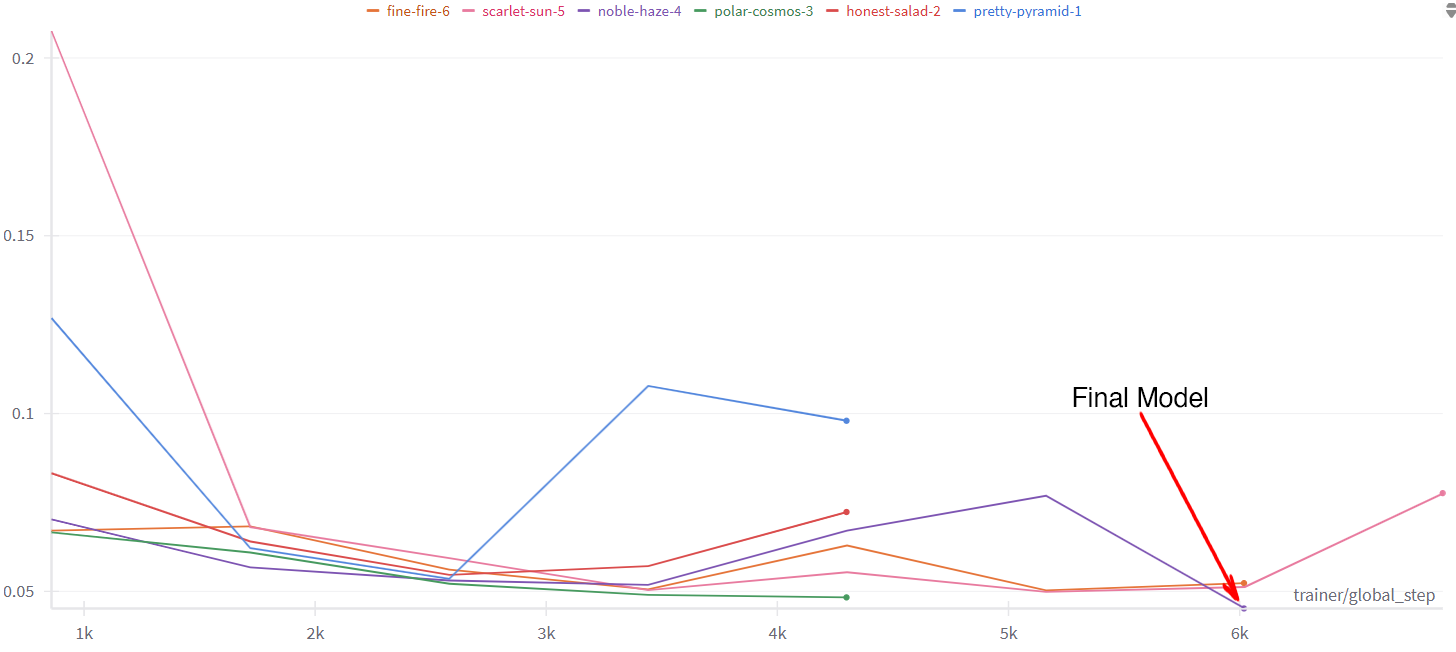

In [39]:
display(
    HTML(
        "<h3 style='margin-left: 18%; font-weight: normal;'>Validation Loss Progression During Transfer Learning (400 Tokens)</h3>"
    )
)
display(IPimage("Pictures/transfer_learning.png", width=1000))

- The lowest validation loss achieved during training was 0.045 on a sequence length of 512 tokens. For 400 tokens, this was reached with the learning rate of 5e-3 and 7 epochs.  
- I then tested shorter sequence lengths—350 and 300—but the loss began to increase below 400. As a result, 400 tokens was chosen as the final sequence length.
- With a single final transformer layer unfrozen, the model achieved a validation loss of 0.01.

## Preprocess and Make Predictions

In [40]:
device = torch.device("cuda")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")
model = DistilBertForSequenceClassification.from_pretrained(
    "transfer_learning_400_highest_original"
).to(device)
model.eval()
sequence_length = 400

original_test["label"] = (original_test["label"] == "True").astype(int)
new_test["label"] = (new_test["label"] == "True").astype(int)

original_test_dataset = NewsDataset(
    original_test["text"].tolist(),
    original_test["label"].values,
    tokenizer,
    max_length=sequence_length,
)
new_test_dataset = NewsDataset(
    new_test["text"].tolist(),
    new_test["label"].values,
    tokenizer,
    max_length=sequence_length,
)
origianl_test_loader = DataLoader(original_test_dataset, batch_size=32, shuffle=False)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

news_test_preds = predict(origianl_test_loader, original_test, model)
new_news_preds = predict(new_test_loader, new_test, model)

100%|██████████| 188/188 [03:55<00:00,  1.25s/it]


## Performance Evaluation

,Model,pr_auc,roc_auc,accuracy,f1_fake,f1_true,precision_fake,precision_true,recall_fake,recall_true
0,Original Test Set,0.9995,0.9995,0.9920,0.9912,0.9926,0.9901,0.9936,0.9924,0.9917
1,New Test Set,0.7152,0.7433,0.6816,0.7041,0.6554,0.6615,0.7084,0.7525,0.6097


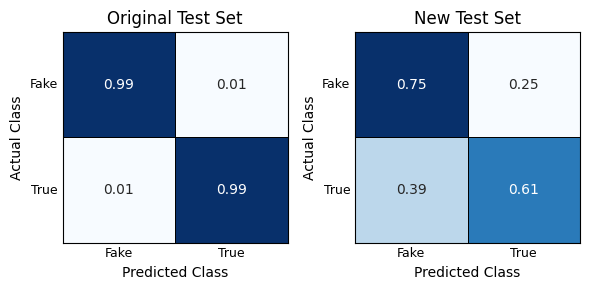

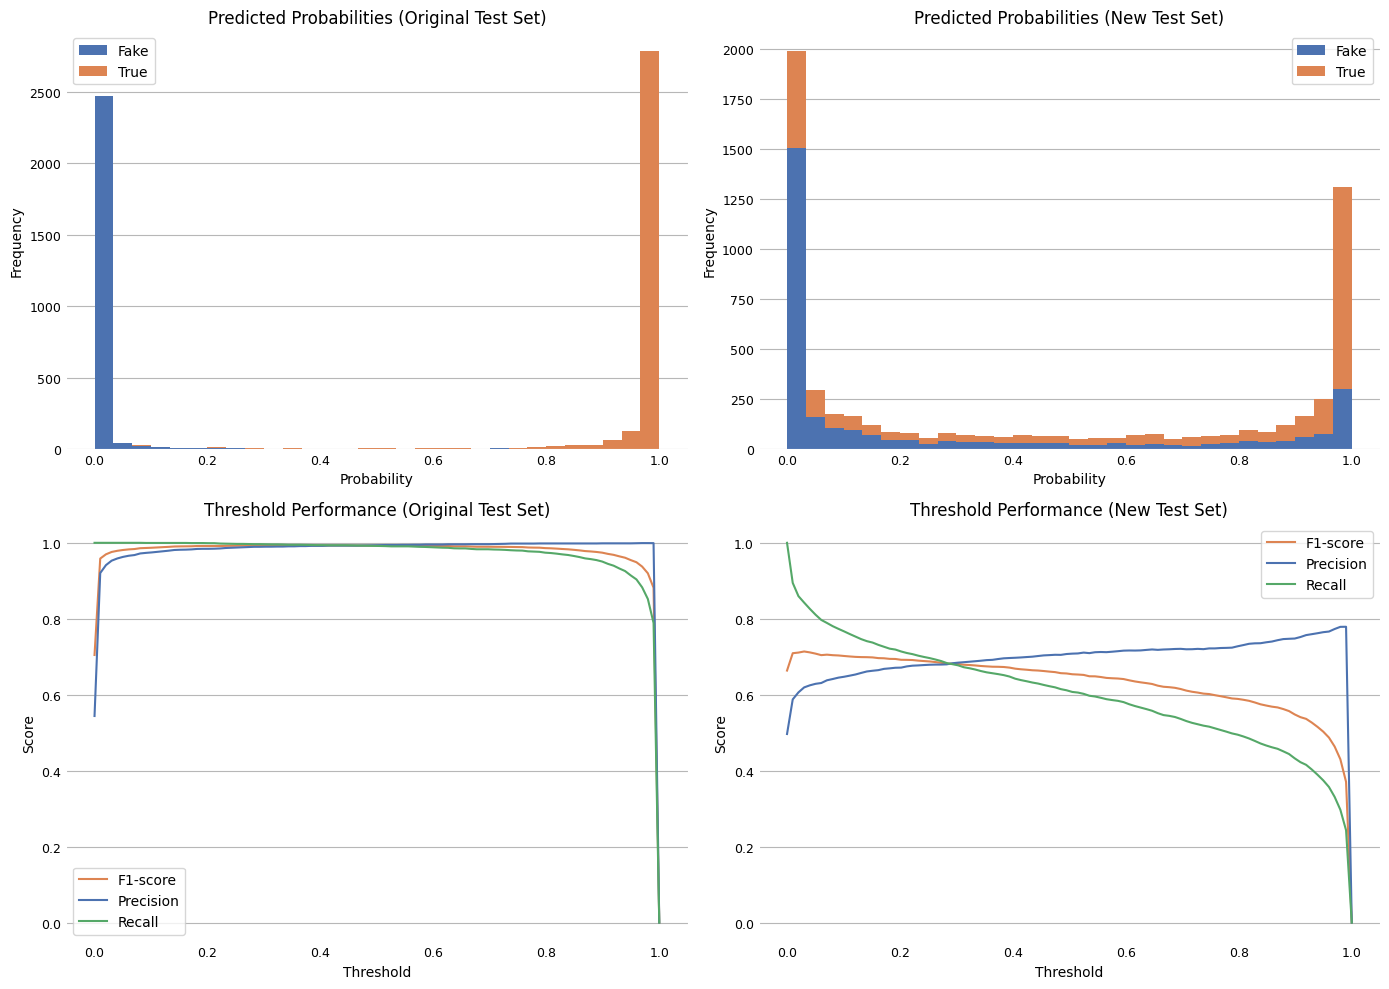

In [41]:
y_test = news_test_preds["label"].values
y_pred_test = news_test_preds["predicted_label"].values
y_prob_test = news_test_preds["predicted_prob_true"].values

y_new = new_news_preds["label"].values
y_pred_new = new_news_preds["predicted_label"].values
y_prob_new = new_news_preds["predicted_prob_true"].values

# Evaluation metrics
result_test = evaluate_model(
    y_test, y_pred_test, y_prob_test, model_name="Original Test Set"
)
result_new = evaluate_model(y_new, y_pred_new, y_prob_new, model_name="New Test Set")
combined_results = pd.DataFrame([result_test, result_new]).round(4)
display(combined_results)

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

plot_confusion_matrix(
    ["True" if y else "Fake" for y in news_test_preds["label"]],
    ["True" if y else "Fake" for y in news_test_preds["predicted_label"]],
    title="Original Test Set",
    ax=axes[0],
)

plot_confusion_matrix(
    ["True" if y else "Fake" for y in new_news_preds["label"]],
    ["True" if y else "Fake" for y in new_news_preds["predicted_label"]],
    title="New Test Set",
    ax=axes[1],
)

plt.tight_layout()
plt.show()

# Predicted Probabilities
thresholds = np.linspace(0, 1, 100)

f1_test = [f1_score(y_test, y_prob_test >= t, zero_division=0) for t in thresholds]
prec_test = [
    precision_score(y_test, y_prob_test >= t, zero_division=0) for t in thresholds
]
rec_test = [recall_score(y_test, y_prob_test >= t, zero_division=0) for t in thresholds]

f1_new = [f1_score(y_new, y_prob_new >= t, zero_division=0) for t in thresholds]
prec_new = [
    precision_score(y_new, y_prob_new >= t, zero_division=0) for t in thresholds
]
rec_new = [recall_score(y_new, y_prob_new >= t, zero_division=0) for t in thresholds]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(
    [y_prob_test[y_test == 0], y_prob_test[y_test == 1]],
    stacked=True,
    bins=30,
    color=["#4C72B0", "#DD8452"],
    label=["Fake", "True"],
    zorder=2,
)
axes[0, 0].set_title("Predicted Probabilities (Original Test Set)")
axes[0, 0].set_xlabel("Probability")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()
axes[0, 1].hist(
    [y_prob_new[y_new == 0], y_prob_new[y_new == 1]],
    stacked=True,
    bins=30,
    color=["#4C72B0", "#DD8452"],
    label=["Fake", "True"],
    zorder=2,
)
axes[0, 1].set_title("Predicted Probabilities (New Test Set)")
axes[0, 1].set_xlabel("Probability")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].legend()

# Threshold curves
axes[1, 0].plot(thresholds, f1_test, label="F1-score", color="#DD8452", zorder=2)
axes[1, 0].plot(thresholds, prec_test, label="Precision", color="#4C72B0", zorder=2)
axes[1, 0].plot(thresholds, rec_test, label="Recall", color="#55A868", zorder=2)
axes[1, 0].set_title("Threshold Performance (Original Test Set)")
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("Score")
axes[1, 0].legend()

axes[1, 1].plot(thresholds, f1_new, label="F1-score", color="#DD8452", zorder=2)
axes[1, 1].plot(thresholds, prec_new, label="Precision", color="#4C72B0", zorder=2)
axes[1, 1].plot(thresholds, rec_new, label="Recall", color="#55A868", zorder=2)
axes[1, 1].set_title("Threshold Performance (New Test Set)")
axes[1, 1].set_xlabel("Threshold")
axes[1, 1].set_ylabel("Score")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

- The transformer trained with only the output layer outperforms LightGBM. On the original test set, the transformer achieved a PR AUC of 0.9995 and accuracy of 0.9920, compared to 0.9990 and 0.986 for the ML model—both very high.  
- The transformer also performs significantly better on the new test set, reaching a PR AUC of 0.7152 and accuracy of 0.7152, while LightGBM only achieved 0.597 and 0.543.  
- LightGBM showed a strong bias toward predicting fake news, while the transformer is better at distinguishing between the two classes much better.
- When a single transformer layer was fine-tuned, the validation loss dropped from 0.045 (current model) to 0.01.

## LIME Analysis

LIME was used to explain individual predictions by randomly sampling texts from the dataset. For each word the scores were averaged across all samples and ranked by absolute value. The top words with the strongest average impact—whether positively or negatively influencing the prediction—were returned.

In [42]:
explainer = LimeGlobalImportanceExplainer(
    model, tokenizer, ["Fake", "True"], news_test_preds["text"].tolist()
)
print("Original dataset most impactful words:")
explainer.explain_average_importance(num_samples=160, num_features=20)

explainer = LimeGlobalImportanceExplainer(
    model, tokenizer, ["Fake", "True"], new_news_preds["text"].tolist()
)
print("New dataset most impactful words:")
explainer.explain_average_importance(num_samples=160, num_features=20)

Original dataset most impactful words:


,Word,Avg Importance
0,instilled,0.289239
1,paid,0.274610
2,treaties,0.274430
3,Kerry,0.271584
4,spokeswoman,0.267464
5,oil,0.259617
6,109,0.249861
7,counsel,0.242757
8,proposal,0.239866
9,negotiations,0.232675


New dataset most impactful words:


,Word,Avg Importance
0,nonprofit,0.335019
1,law,0.280902
2,customary,0.252252
3,Jason,0.245934
4,tonight,0.245554
5,lasted,0.241876
6,night,0.239140
7,spokesman,0.237829
8,Nigeria,0.236485
9,Tuyl,0.235669


- The importnat words are comletedly different between the datasets and between what was visible on SHAP or n-grams. They seem random, but this is expected as the transformer did not learn from the data.

## Error Analysis

### Case Inspection

In [43]:
misclassified_transformer_indices = np.where(
    news_test_preds["label"].astype(int).values
    != news_test_preds["predicted_label"].astype(int).values
)[0]

misclassifications_transformer = original_test.iloc[
    misclassified_transformer_indices
].copy()
misclassifications_transformer["true_label"] = news_test_preds.iloc[
    misclassified_transformer_indices
]["label"].values
misclassifications_transformer["predicted_label"] = news_test_preds.iloc[
    misclassified_transformer_indices
]["predicted_label"].values

misclassified_ml_indices = np.where(y_original_test != y_pred_original_test)[0]
shared_indices = np.intersect1d(
    misclassified_transformer_indices, misclassified_ml_indices
)

misclassifications_transformer.drop(columns=["label"], inplace=True)
preview_text(misclassifications_transformer, 800, 1, "start")
print("Transformer misclassified samples:", misclassifications_transformer.shape[0])
print("Shared misclassifications (Transformer and ML):", len(shared_indices))

,title,text,subject,date,true_label,predicted_label
2713,Putin and Trump to Potentially Meet in Slovenia,"21st Century Wire says The Russian President, Vladimir Putin, had his first phone meeting with President Donald Trump after his inauguration in January and now it looks like the ground work is being laid for the first face to face meeting with Trump in person, perhaps in Slovenia.There certainly is a lot to discuss between trade, economic issues, security and of course terrorism. Putin noted, By joining our efforts, we could make a considerable contribution to settling these issues, including fighting international terrorism RT explores this report further in the below article. RT Ljubljana and Slovenia in general is of course a great place to hold such dialogue, Putin said on Friday.Putin, who is currently welcoming Slovenian President Borut Pahor in Russia on an official visit, than",Middle-east,2017-02-10,0,1


Transformer misclassified samples: 46
Shared misclassifications (Transformer and ML): 6


- Misclassifications appear typical and do not show any unusual patterns.
- They are mostly different between the LightGBM and the transformer. 

### Individual Instance Analysis

In [44]:
explainer_misclassified = LimeExplainerMisclassifiedSamples(
    model=model,
    tokenizer=tokenizer,
    target_labels=["Fake", "True"],
    texts=misclassifications_transformer["text"].tolist(),
    true_labels=misclassifications_transformer["true_label"].tolist(),
    predicted_labels=misclassifications_transformer["predicted_label"].tolist(),
)
explainer_misclassified.explain_random(num_samples=3, num_features=10)

True Label: Fake | Predicted Label: True
Text:
Hey Bernie The first step in fighting corruption by politicians might start with cleaning up the corruption in your own campaign Thousands of contributions to Democratic presidential candidate Bernie
Sanders  campaign in January violated federal campaign finance laws, election regulators said on Thursday.The Federal Election Commission sent a letter to the Democratic presidential candidate s
campaign committee on Thursday with a 90-page spreadsheet listing 3,457  excessive, prohibited, and impermissible contributions. The campaign s January financial disclosure filing listed contributions
from...



,Token,LIME Score
0,filing,0.066970
1,as,0.056058
2,nationals,0.050989
3,illegal,0.046780
4,immediately,0.044151
5,kind,0.040133
6,Senator,0.035644
7,at,0.008053
8,Although,0.007379
9,and,0.001435


True Label: Fake | Predicted Label: True
Text:
Of course, we d be okay with excluding three of the Justices who didn t go along with the rubber stamping of Obama s reckless socialized medicine plan. While we re at it, it s only fair for Barry and
his family to be forced to use his signature  Obamacare  insurance plan as well A House Republican on Thursday proposed forcing the Supreme Court justices and their staff to enroll in ObamaCare.Rep.
Brian Babin (R-Texas) said that his SCOTUScare Act would make all nine justices and their employees join the national healthcare law s exchanges. As the Supreme Court continues to ignore the letter of
...



,Token,LIME Score
0,be,0.082901
1,deserve,0.060658
2,was,0.040251
3,mandate,0.040191
5,rubber,0.034893
6,ruling,0.028559
8,6,0.017591
9,potential,0.000034
7,they,-0.022278
4,people,-0.035612


True Label: True | Predicted Label: Fake
Text:
SEOUL (Reuters) - After months of fiery rhetoric and rising tensions, U.S. President Donald Trump s secret attempt to personally face off with North Korea across the heavily fortified demilitarized
zone (DMZ) on Wednesday was defeated by fog and mist. Helicopters carrying Trump and an entourage of staff, media, and security forces were turned back just minutes from the DMZ, thwarting a plan that
had been in the works since before the president left on his trip through Asia.  He s actually pretty frustrated,  Press Secretary Sarah Huckabee Sanders said of Trump. Often clad in photo-friendly
bom...



,Token,LIME Score
1,t,0.034296
2,have,0.033950
3,plan,0.033756
4,back,0.029014
7,Secretary,0.010287
9,guys,0.006710
8,be,-0.007823
6,previously,-0.019378
5,look,-0.025899
0,s,-0.053158


- The most important tokens used do not show any noticeable logic.

# Conclusions

This project explored fake news classification on political news articles using both traditional machine learning and deep learning approaches. In practice, "fake" refers to emotionally charged or opinion-based language, while "true" is neutral, fact-based reporting. The original dataset showed strong bias: all true-labeled articles came from a single source—Reuters—while fake news came from a variety of sources. To evaluate generalizability more fairly, a new test set from a different source was introduced.

The data cleaning process revealed several additional issues, including data leakage through repeated patterns like news agency names, Twitter links, and embedded metadata such as image credits. These patterns were removed from the training set. A total of 631 rows with whitespace-only text were removed, along with 5999 duplicate entries, resulting in 38268 rows remaining. Some entries may be considered anomalous—such as very short texts, advertisements, and tweet reposts—but since the exact nature of the production environment is unknown, they were kept in the dataset. Further analysis showed that fake and true articles came from distinct subject categories, further highlighting the dataset’s bias.

A rule-based baseline using n-grams reached 82% accuracy, showing that simple heuristics could perform well on this dataset. However, performance dropped to 52% on the new test set—close to the level of random guessing. Machine learning models trained on TF-IDF features performed exceptionally on the original test set, reaching a PR AUC of 0.999 and accuracy of 0.987. But on the new test set, their performance dropped sharply to 0.599 PR AUC and 0.53 accuracy—barely above the rule-based baseline.

Given the risk of severe overfitting, I chose not to fine-tune the full transformer and instead trained only the classifier head. This approach still achieved slightly better results on the original test set (PR AUC 0.9995, accuracy 0.992) and significantly stronger results on the new test set (PR AUC 0.715, accuracy 0.682), which was expected. This was reached using 400 tokens, which matched the lowest validation loss achieved with the full 512-token input.

#### Major Improvements

- Use more diverse and balanced training data: The current dataset is highly biased, especially for the true label, which is entirely based on Reuters. A larger and more balanced source for true news would greatly improve generalization. This was not possible in this project, as the new dataset that I found was 6 times smaller than the original.
- Define a more granular labeling objective: Unlike Ground News, which uses multi-tier factuality ratings ("Very Low", "Low", "High", "Very High") at the organization level, this project relies on a binary "True/Fake" label. If the goal is to build a user-facing tool, a multi-class system would better reflect the complexity of real-world news quality.

#### Other Important Improvements

- Remove or anonymize named entities: Mentions of news agencies like "Reuters" could leak label information and should ideally be removed or masked. I di not do this initialy, as I sow few other news agencies being named. Further review would be needed to apply this consistently.
- Improve duplicate detection: Some articles might be near-duplicates with only minor word changes. A similarity-based method could catch more of these cases than exact title/text matching.
- Test real examples with misleading content: Evaluate model predictions on crafted phrases like "Obama is not an American" (which was a popular conspiracy) to better understand how the model behaves on short or controversial claims. This is especially relevant given that many short articles in the dataset were labeled as fake and this may bias the prediction for short texts. Many more types or texts could be tested.
- Include article titles: Titles can be concatenated to the beginning of the text using for a transformer with a special separator token "[SEP]". They may provide helpful context for classification and improve model accuracy. But this is important only if there is new more diverse data and the performance falls.
- Experiment with word embeddings: While not tested here due to dataset bias, using pretrained word embeddings (e.g., Word2Vec) for ML models could more resilient to overfitting.

#### Additional Ideas

- Test impact of data leakage: For educational purposes, it could be interesting to train a model with leaking patterns and manipulate their placement in the text to measure impact on predictions.
- Fine-tune with phrase-based leakage removal: Instead of removing general patterns, test removing only the exact leaked phrase to keep as much useful content as possible.
- Avoid unigrams for generalization: Limiting TF-IDF to only bigrams may help reduce overfitting and improve generalizability.
- Fine-tune a larger transformer model: If the dataset is improved, it would be worth fine-tuning larger architecture like RoBERTa or ModernBERT, which support longer sequences.
- Additional non-TF-IDF, text structure features like average word length, punctuation use, uppercase ratio could be created.
- Find the exact optimal TF-IDF feature count using Bayesian hyperparameter optimization. This was not done due to long optimization times.
- New test dataset contained some duplicates and it could be examind what exactly was duplicated.